In [3]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [4]:
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

2024-06-23 10:27:39.056275: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-23 10:27:39.339820: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-23 10:27:40.191450: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
df = pd.read_csv('/home/thu/LaptrinhAI/Final_term/hanoi-aqi-weather-data.csv',
                 parse_dates=['Local Time', 'UTC Time'],
                 index_col=['Local Time'])
df.head()

UTC Time   City Country Code          Timezone  \
Local Time                                                                      
2023-06-08 00:00:00 2023-06-07 17:00:00  Hanoi           VN  Asia/Ho_Chi_Minh   
2023-06-08 01:00:00 2023-06-07 18:00:00  Hanoi           VN  Asia/Ho_Chi_Minh   
2023-06-08 02:00:00 2023-06-07 19:00:00  Hanoi           VN  Asia/Ho_Chi_Minh   
2023-06-08 03:00:00 2023-06-07 20:00:00  Hanoi           VN  Asia/Ho_Chi_Minh   
2023-06-08 04:00:00 2023-06-07 21:00:00  Hanoi           VN  Asia/Ho_Chi_Minh   

                     AQI     CO   NO2    O3  PM10  PM25   SO2  Clouds  \
Local Time                                                              
2023-06-08 00:00:00  118  168.7  32.3  74.7  52.5  42.0  57.3      37   
2023-06-08 01:00:00  115  169.8  32.0  66.0  51.3  41.0  64.0      50   
2023-06-08 02:00:00  112  166.7  29.3  63.7  50.0  40.0  66.0      62   
2023-06-08 03:00:00  121  163.6  26.7  61.3  53.8  43.0  68.0      75   
2023-06-08 04:00:00  134  160.5  24.0  59.0  60.0  48.0  70.0      87   

                     Precipitation  Pressure  Relative Humidity  Temperature  \
Local Time                                                                     
2023-06-08 00:00:00            0.5      1004                 87         29.3   
2023-06-08 01:00:00            1.0      1004                 88         29.0   
2023-06-08 02:00:00            1.0      1003                 89         28.9   
2023-06-08 03:00:00            0.5      1003                 90         28.7   
2023-06-08 04:00:00            0.0      1003                 92         28.6   

                     UV Index  Wind Speed  
Local Time                                 
2023-06-08 00:00:00       0.0        1.33  
2023-06-08 01:00:00       0.0        1.00  
2023-06-08 02:00:00       0.0        0.66  
2023-06-08 03:00:00       0.0        0.33  
2023-06-08 04:00:00       0.0        1.20

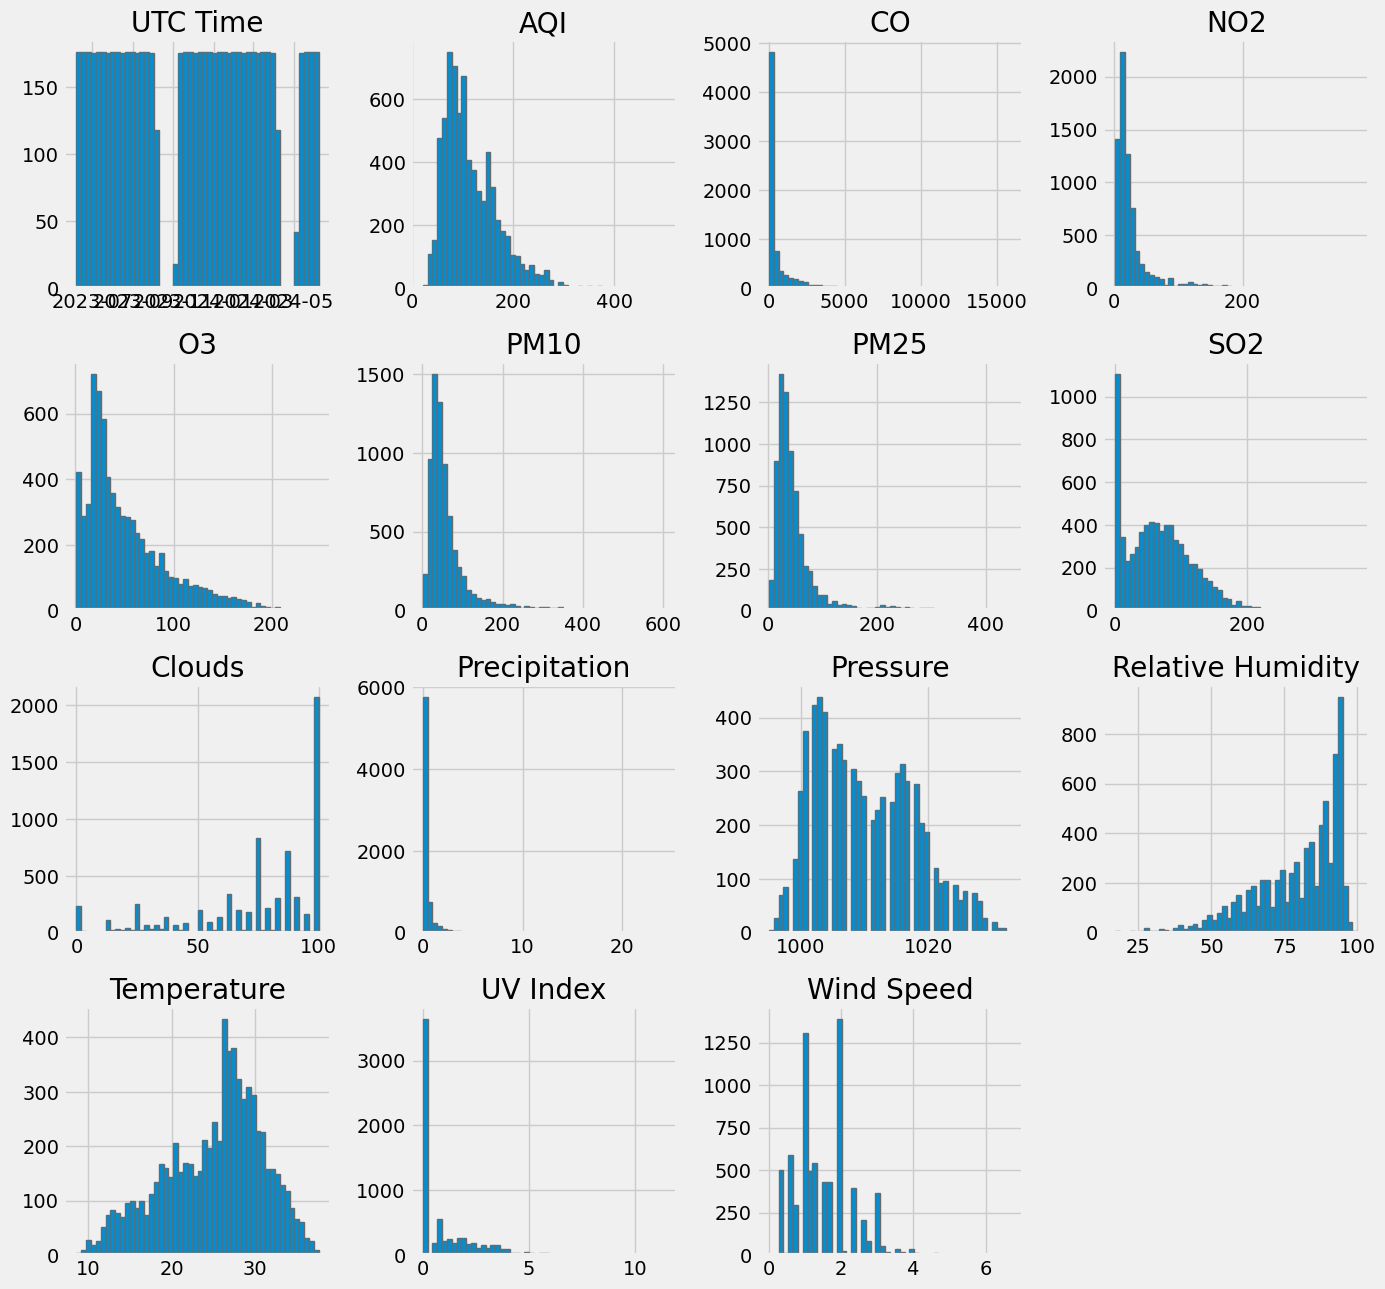

In [6]:
df.hist(bins=50, figsize=(15,15));

# Data Wrangling

## Missing Value

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7323 entries, 2023-06-08 00:00:00 to 2024-06-08 00:00:00
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   UTC Time           7323 non-null   datetime64[ns]
 1   City               7323 non-null   object        
 2   Country Code       7323 non-null   object        
 3   Timezone           7323 non-null   object        
 4   AQI                7323 non-null   int64         
 5   CO                 7323 non-null   float64       
 6   NO2                7323 non-null   float64       
 7   O3                 7323 non-null   float64       
 8   PM10               7323 non-null   float64       
 9   PM25               7323 non-null   float64       
 10  SO2                7323 non-null   float64       
 11  Clouds             7323 non-null   int64         
 12  Precipitation      7323 non-null   float64       
 13  Pressure           7323 non

In [8]:
df.isnull().sum()

UTC Time             0
City                 0
Country Code         0
Timezone             0
AQI                  0
CO                   0
NO2                  0
O3                   0
PM10                 0
PM25                 0
SO2                  0
Clouds               0
Precipitation        0
Pressure             0
Relative Humidity    0
Temperature          0
UV Index             0
Wind Speed           0
dtype: int64

In [9]:
df.shape

(7323, 18)

In [10]:
df.describe()

UTC Time          AQI            CO          NO2  \
count                           7323  7323.000000   7323.000000  7323.000000   
mean   2023-11-28 20:58:02.015567360   116.585689    689.296736    29.826806   
min              2023-06-07 17:00:00    21.000000      9.000000     2.000000   
25%              2023-08-22 23:30:00    76.000000    129.600000    11.000000   
50%              2023-12-08 05:00:00   102.000000    202.000000    17.300000   
75%              2024-02-22 11:30:00   151.000000    605.000000    30.000000   
max              2024-06-07 17:00:00   500.000000  15956.200000   378.000000   
std                              NaN    55.780160   1252.939417    37.224108   

                O3         PM10         PM25          SO2       Clouds  \
count  7323.000000  7323.000000  7323.000000  7323.000000  7323.000000   
mean     52.687396    64.847016    50.093733    67.637799    72.991260   
min       1.000000     1.300000     1.000000     0.000000     0.000000   
25%      21.300000    30.600000    23.500000    26.000000    61.500000   
50%      39.000000    46.000000    35.000000    63.000000    79.000000   
75%      73.000000    72.500000    54.500000    99.000000   100.000000   
max     248.000000   604.000000   446.000000   368.000000   100.000000   
std      42.986051    62.242520    51.428854    50.246253    28.078716   

       Precipitation     Pressure  Relative Humidity  Temperature  \
count    7323.000000  7323.000000        7323.000000  7323.000000   
mean        0.358562  1010.077154          79.274887    25.037881   
min         0.000000   995.000000          17.000000     8.600000   
25%         0.000000  1004.000000          70.000000    20.800000   
50%         0.000000  1009.000000          84.000000    26.200000   
75%         0.000000  1016.000000          92.000000    29.200000   
max        24.250000  1033.000000         100.000000    37.600000   
std         1.269800     7.758417          15.033467     5.917315   

          UV Index   Wind Speed  
count  7323.000000  7323.000000  
mean      1.260085     1.545976  
min       0.000000     0.000000  
25%       0.000000     1.000000  
50%       0.600000     1.330000  
75%       2.000000     2.000000  
max      11.400000     6.700000  
std       1.837839     0.806536

Xác định biến mục tiêu

<Axes: >

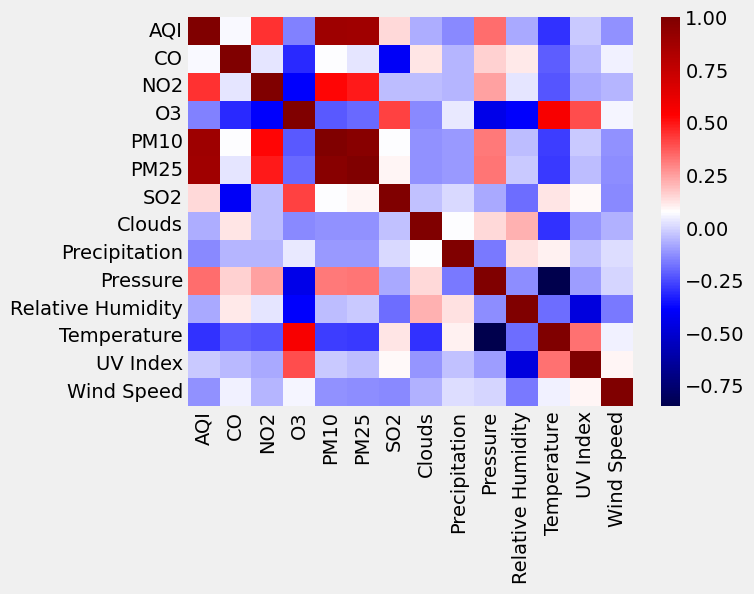

In [11]:
df_num = df[['AQI', 'CO', 'NO2',
       'O3', 'PM10', 'PM25', 'SO2', 'Clouds', 'Precipitation', 'Pressure',
       'Relative Humidity', 'Temperature', 'UV Index', 'Wind Speed']]
data = df_num.copy(deep=True)
sns.heatmap(data.corr(), cmap='seismic')

In [12]:
data

AQI      CO   NO2    O3  PM10   PM25   SO2  Clouds  \
Local Time                                                                
2023-06-08 00:00:00  118   168.7  32.3  74.7  52.5  42.00  57.3      37   
2023-06-08 01:00:00  115   169.8  32.0  66.0  51.3  41.00  64.0      50   
2023-06-08 02:00:00  112   166.7  29.3  63.7  50.0  40.00  66.0      62   
2023-06-08 03:00:00  121   163.6  26.7  61.3  53.8  43.00  68.0      75   
2023-06-08 04:00:00  134   160.5  24.0  59.0  60.0  48.00  70.0      87   
...                  ...     ...   ...   ...   ...    ...   ...     ...   
2024-06-07 20:00:00   67   968.9  21.7  27.3  35.4  20.09   4.0      70   
2024-06-07 21:00:00   55   957.0  19.4  29.1  23.9  14.10   4.0      66   
2024-06-07 22:00:00   49  1583.2  20.3  35.2  20.6  11.73   4.0      62   
2024-06-07 23:00:00   51  1155.5  20.0  29.7  21.7  12.36   4.0      75   
2024-06-08 00:00:00   54  2410.3  38.5  39.1  19.0  13.80  55.3      87   

                     Precipitation  Pressure  Relative Humidity  Temperature  \
Local Time                                                                     
2023-06-08 00:00:00           0.50      1004                 87         29.3   
2023-06-08 01:00:00           1.00      1004                 88         29.0   
2023-06-08 02:00:00           1.00      1003                 89         28.9   
2023-06-08 03:00:00           0.50      1003                 90         28.7   
2023-06-08 04:00:00           0.00      1003                 92         28.6   
...                            ...       ...                ...          ...   
2024-06-07 20:00:00           1.00      1003                 89         28.2   
2024-06-07 21:00:00           1.75      1004                 92         27.5   
2024-06-07 22:00:00           2.25      1004                 95         26.7   
2024-06-07 23:00:00           1.75      1004                 95         26.8   
2024-06-08 00:00:00           0.75      1003                 95         26.9   

                     UV Index  Wind Speed  
Local Time                                 
2023-06-08 00:00:00       0.0        1.33  
2023-06-08 01:00:00       0.0        1.00  
2023-06-08 02:00:00       0.0        0.66  
2023-06-08 03:00:00       0.0        0.33  
2023-06-08 04:00:00       0.0        1.20  
...                       ...         ...  
2024-06-07 20:00:00       0.0        2.00  
2024-06-07 21:00:00       0.0        2.00  
2024-06-07 22:00:00       0.0        2.00  
2024-06-07 23:00:00       0.0        1.66  
2024-06-08 00:00:00       0.0        1.33  

[7323 rows x 14 columns]

In [13]:
# calculate quantile from each attributes
def calculate_quantile (i, data):
    Q1 = data[[i]].quantile(0.25)[0]
    Q3 = data[[i]].quantile(0.75)[0]
    IQR = Q3 - Q1
    min = data[[i]].min()[0]
    max = data[[i]].max()[0]
    min_IQR = Q1 - 1.5*IQR
    max_IQR = Q3 + 1.5*IQR
    
    return Q1, Q3, min, max, min_IQR, max_IQR

# delete first and last rows to avoid missing value extrapolation
data.drop(index=[data.index[0], data.index[data.shape[0]-1]], inplace=True)

# find and interpolate the outliers
for i in data.columns:
    print('\nAttribute-',i,':')
    Q1, Q3, min, max, min_IQR, max_IQR = calculate_quantile(i, data)
    print('Q1 = %.2f' % Q1)
    print('Q3 = %.2f' % Q3)
    print('min IQR = %.2f' % min_IQR)
    print('max IQR = %.2f' % max_IQR)
    if (min < min_IQR):
        print('---> Low outlier is found = %.2f' % min)
    if (max > max_IQR):
        print('---> High outlier is found = %.2f' % max)
    
    def convert_nan (x, max_IQR=max_IQR, min_IQR=min_IQR):
        if ((x > max_IQR) | (x < min_IQR)):
            x = np.nan
        else:
            x = x
        return x

    def convert_nan_HUM (x, max_IQR=100.0, min_IQR=min_IQR):
        if ((x > max_IQR) | (x < min_IQR)):
            x = np.nan
        else:
            x = x
        return x
    
    if (i == 'HUM'):
        data[i] = data[i].map(convert_nan_HUM)
        data[i] = data[i].interpolate(method='linear')
    if (i != 'HUM'):
        data[i] = data[i].map(convert_nan)
        data[i] = data[i].interpolate(method='linear')
         
    if (len(data[data[i].isnull()][i]) == 0):
        print('################  Outliers have been interpolated  ################')


Attribute- AQI :
Q1 = 76.00
Q3 = 151.00
min IQR = -36.50
max IQR = 263.50
---> High outlier is found = 500.00
################  Outliers have been interpolated  ################

Attribute- CO :
Q1 = 129.60
Q3 = 605.00
min IQR = -583.50
max IQR = 1318.10
---> High outlier is found = 15956.20
################  Outliers have been interpolated  ################

Attribute- NO2 :
Q1 = 11.00
Q3 = 30.00
min IQR = -17.50
max IQR = 58.50
---> High outlier is found = 378.00
################  Outliers have been interpolated  ################

Attribute- O3 :
Q1 = 21.30
Q3 = 73.00
min IQR = -56.25
max IQR = 150.55
---> High outlier is found = 248.00
################  Outliers have been interpolated  ################

Attribute- PM10 :
Q1 = 30.60
Q3 = 72.50
min IQR = -32.25
max IQR = 135.35
---> High outlier is found = 604.00
################  Outliers have been interpolated  ################

Attribute- PM25 :
Q1 = 23.50
Q3 = 54.50
min IQR = -23.00
max IQR = 101.00
---> High outlier is found = 4

1. AQI PRediction

In [30]:
# log transform để xử lý thông tin sai lệch

dataset = np.log1p(data[['AQI']].values)
dataset.shape

(7321, 1)

<Figure size 1200x500 with 0 Axes>

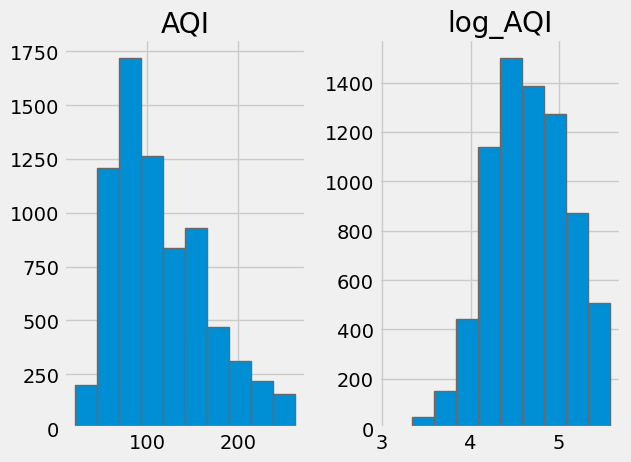

In [31]:
# tạo khung dữ liệu mới để so sánh với dữ liệu gốc và dữ liệu log transform
dist_df = pd.DataFrame({'AQI' : data['AQI'].values, 'log_AQI' : dataset[:,0]})

# Biểu đồ dữ liệu gốc và log transform data
plt.figure(figsize=(12,5))
dist_df.hist();

In [23]:
#Chia data
# # 75% for training, 25% for testing

train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

5490 1831


In [24]:
train

array([[4.75359019],
       [4.72738782],
       [4.80402104],
       ...,
       [4.39444915],
       [4.49980967],
       [4.20469262]])

In [19]:
# chuyển đổi mảng giả trị thành ma trận dataset

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [26]:
# reshape lại thành  X=t and Y=t+1

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print('Shape of trainX :', trainX.shape)
print('Shape of trainY :', trainY.shape)
print('Shape of testX :', testX.shape)
print('Shape of testY :', testY.shape)

Shape of trainX : (5488, 1)
Shape of trainY : (5488,)
Shape of testX : (1829, 1)
Shape of testY : (1829,)


In [27]:
# reshape mảng đầu vào thành: [samples, time steps, features]

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print('Shape of trainX :', trainX.shape)
print('Shape of testX :', testX.shape)

Shape of trainX : (5488, 1, 1)
Shape of testX : (1829, 1, 1)


In [28]:
# tạo và điều chỉnh LSTM Neural Network

model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=500, batch_size=32, verbose=2)

Epoch 1/500


2024-06-23 01:57:56.755948: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


172/172 - 1s - 6ms/step - loss: 21.5560
Epoch 2/500
172/172 - 0s - 900us/step - loss: 14.3385
Epoch 3/500
172/172 - 0s - 835us/step - loss: 8.6520
Epoch 4/500
172/172 - 0s - 884us/step - loss: 3.2094
Epoch 5/500
172/172 - 0s - 986us/step - loss: 0.9633
Epoch 6/500
172/172 - 0s - 849us/step - loss: 0.3403
Epoch 7/500
172/172 - 0s - 971us/step - loss: 0.1775
Epoch 8/500
172/172 - 0s - 976us/step - loss: 0.1401
Epoch 9/500
172/172 - 0s - 878us/step - loss: 0.1324
Epoch 10/500
172/172 - 0s - 852us/step - loss: 0.1308
Epoch 11/500
172/172 - 0s - 802us/step - loss: 0.1296
Epoch 12/500
172/172 - 0s - 830us/step - loss: 0.1286
Epoch 13/500
172/172 - 0s - 853us/step - loss: 0.1274
Epoch 14/500
172/172 - 0s - 817us/step - loss: 0.1262
Epoch 15/500
172/172 - 0s - 832us/step - loss: 0.1246
Epoch 16/500
172/172 - 0s - 967us/step - loss: 0.1230
Epoch 17/500
172/172 - 0s - 966us/step - loss: 0.1212
Epoch 18/500
172/172 - 0s - 1ms/step - loss: 0.1187
Epoch 19/500
172/172 - 0s - 964us/step - loss: 0.11

## Model performance

In [31]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = np.expm1(trainPredict)
trainY = np.expm1(trainY)
testPredict = np.expm1(testPredict)
testY = np.expm1(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Train Score: 25.37 RMSE
Test Score: 28.73 RMSE


In [32]:
test_series = pd.Series(testY)

# state of model performance
if testScore < test_series.std():
    print('\n[ Model performance is GOOD enough ]')
    print('\nRMSE of test prediction < Standard deviation of test dataset')
    print('%.2f' % (testScore), '<', '%.2f' % (test_series.std()))
else:
    print('\n[ Model performance is NOT GOOD enough ]')
    print('\nRMSE of test prediction > Standard deviation of test dataset')
    print('%.2f' % (testScore), '>', '%.2f' % (test_series.std()))


[ Model performance is GOOD enough ]

RMSE of test prediction < Standard deviation of test dataset
28.73 < 45.77


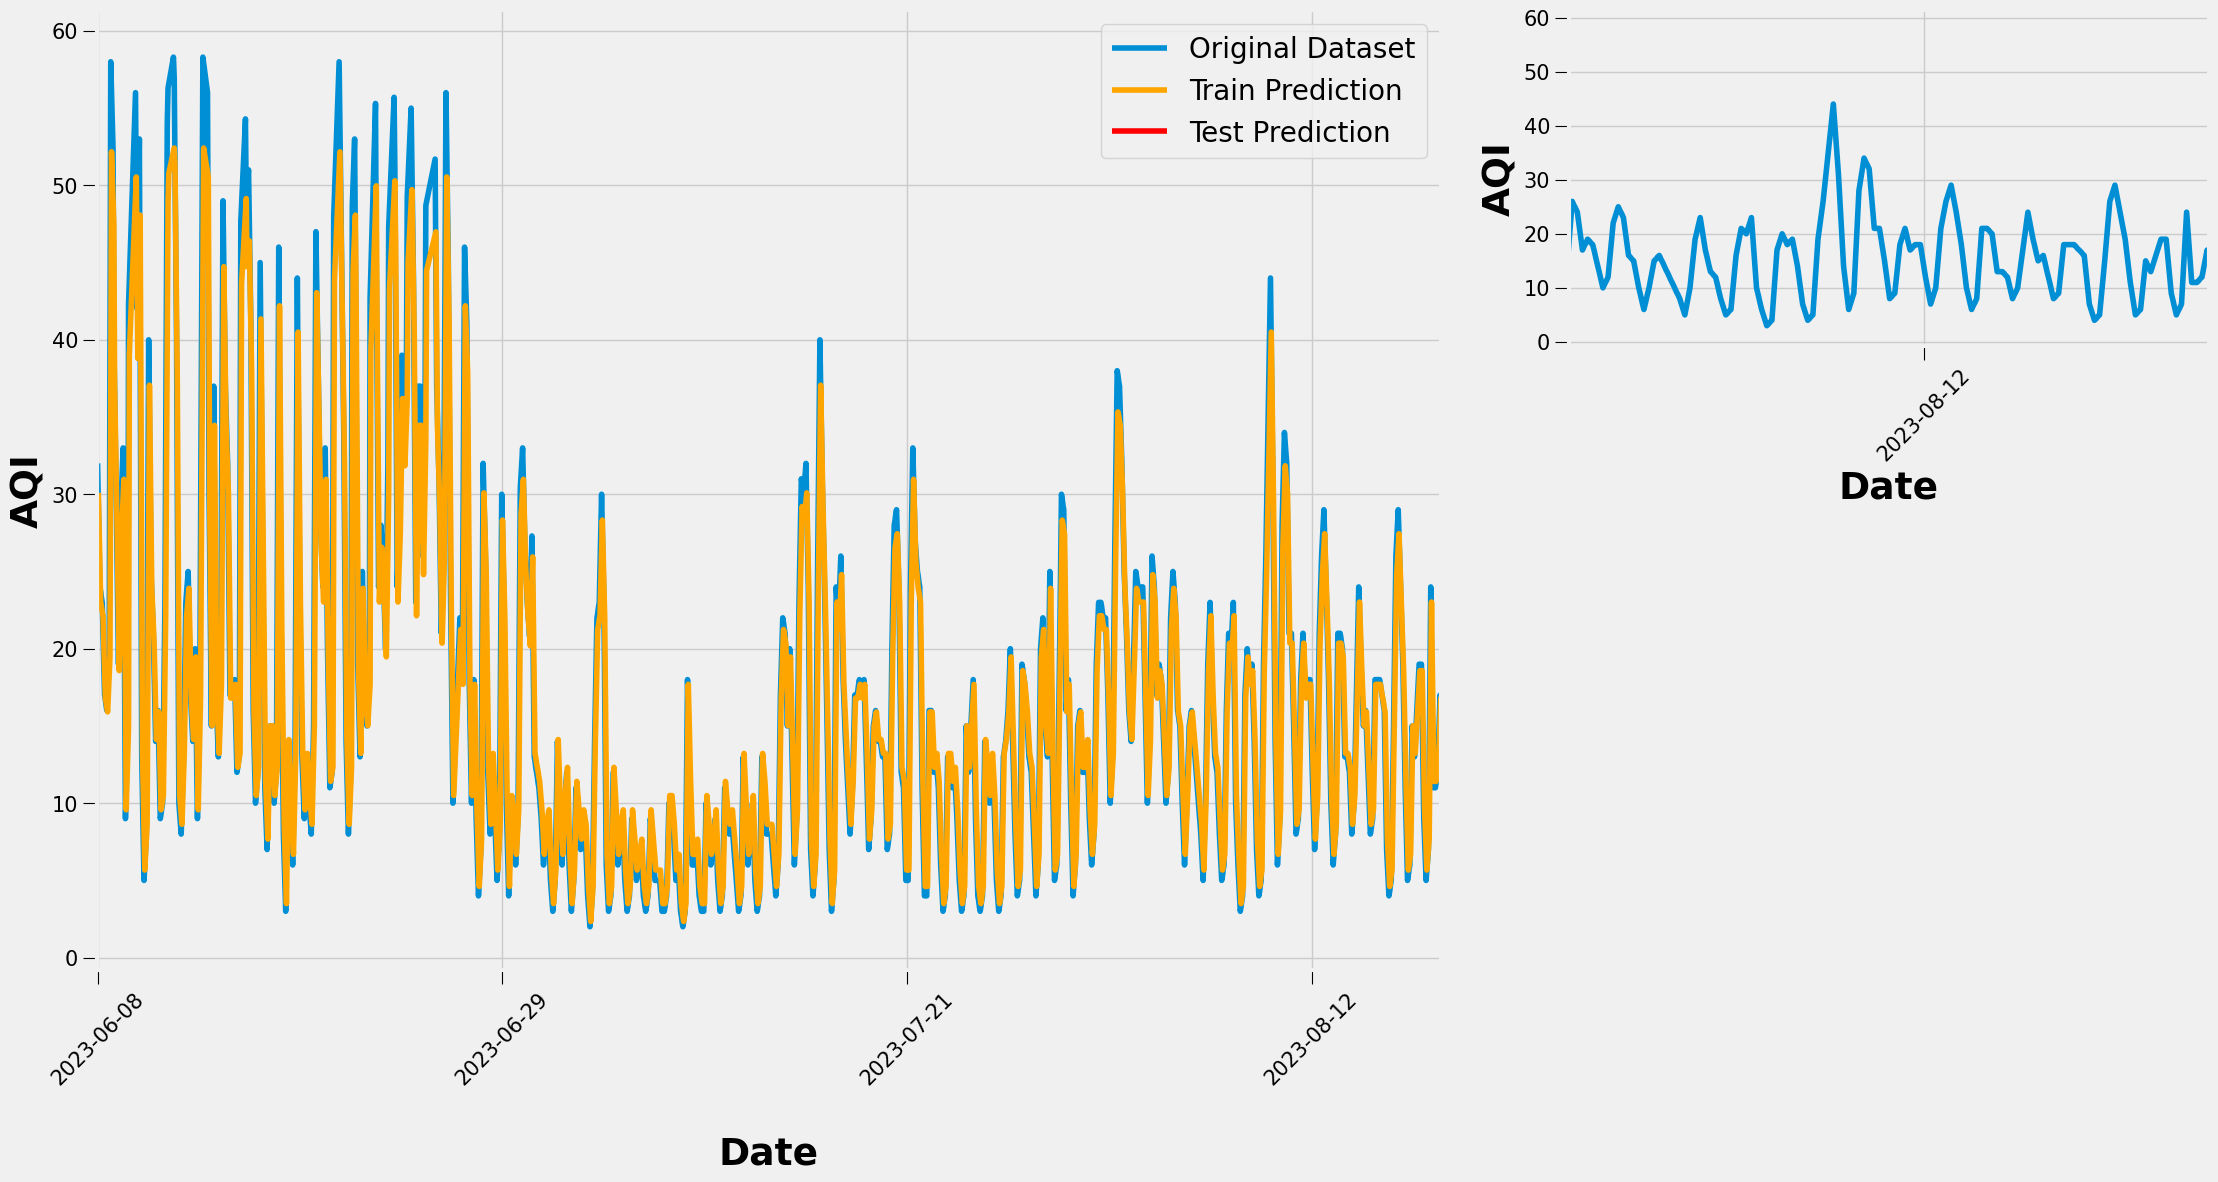

In [53]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot original dataset and predictions
time_axis = np.linspace(0, dataset.shape[0]-1, 15)
time_axis = np.array([int(i) for i in time_axis])
time_axisLab = np.array(data.index, dtype='datetime64[D]')

fig = plt.figure()
ax = fig.add_axes([0, 0, 2.1, 2])
ax.plot(np.expm1(dataset), label='Original Dataset')
ax.plot(trainPredictPlot, color='orange', label='Train Prediction')
ax.plot(testPredictPlot, color='red', label='Test Prediction')
ax.set_xticks(time_axis)
ax.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax.set_xlabel('\nDate', fontsize=27, fontweight='bold')
ax.set_ylabel('AQI', fontsize=27, fontweight='bold')
ax.legend(loc='best', prop= {'size':20})
ax.tick_params(size=10, labelsize=15)
ax.set_xlim([-1,1735])

ax1 = fig.add_axes([2.3, 1.3, 1, 0.7])
ax1.plot(np.expm1(dataset), label='Original Dataset')
ax1.plot(testPredictPlot, color='red', label='Test Prediction')
ax1.set_xticks(time_axis)
ax1.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax1.set_xlabel('Date', fontsize=27, fontweight='bold')
ax1.set_ylabel('AQI', fontsize=27, fontweight='bold')
ax1.tick_params(size=10, labelsize=15)
ax1.set_xlim([1360,1735]);

2. PM2.5 Prediction

In [35]:
data.columns

Index(['AQI', 'CO', 'NO2', 'O3', 'PM10', 'PM25', 'SO2', 'Clouds',
       'Precipitation', 'Pressure', 'Relative Humidity', 'Temperature',
       'UV Index', 'Wind Speed'],
      dtype='object')

In [36]:
dataset = np.log1p(data[['PM25']].values)
dataset.shape

(7321, 1)

<Figure size 1200x500 with 0 Axes>

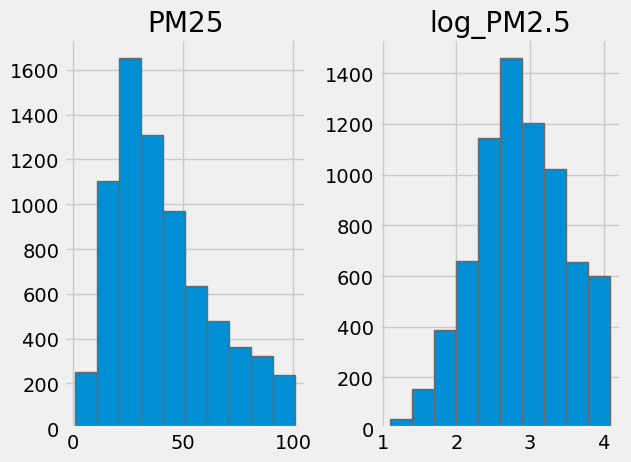

In [72]:
dist_df = pd.DataFrame({'PM25' : data['PM25'].values, 'log_PM2.5' : dataset[:,0]})
plt.figure(figsize=(12,5))
dist_df.hist();

In [38]:
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

5490 1831


In [39]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print('Shape of trainX :', trainX.shape)
print('Shape of trainY :', trainY.shape)
print('Shape of testX :', testX.shape)
print('Shape of testY :', testY.shape)

Shape of trainX : (5488, 1)
Shape of trainY : (5488,)
Shape of testX : (1829, 1)
Shape of testY : (1829,)


In [40]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print('Shape of trainX :', trainX.shape)
print('Shape of testX :', testX.shape)

Shape of trainX : (5488, 1, 1)
Shape of testX : (1829, 1, 1)


In [41]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1500, batch_size=32, verbose=2)

Epoch 1/1500
172/172 - 1s - 8ms/step - loss: 9.1170
Epoch 2/1500
172/172 - 0s - 2ms/step - loss: 4.8430
Epoch 3/1500
172/172 - 0s - 2ms/step - loss: 1.8138
Epoch 4/1500
172/172 - 0s - 1ms/step - loss: 0.6458
Epoch 5/1500
172/172 - 0s - 1ms/step - loss: 0.3268
Epoch 6/1500
172/172 - 0s - 1ms/step - loss: 0.2517
Epoch 7/1500
172/172 - 0s - 2ms/step - loss: 0.2227
Epoch 8/1500
172/172 - 0s - 1ms/step - loss: 0.1878
Epoch 9/1500
172/172 - 0s - 1ms/step - loss: 0.1583
Epoch 10/1500
172/172 - 0s - 2ms/step - loss: 0.1362
Epoch 11/1500
172/172 - 0s - 2ms/step - loss: 0.1213
Epoch 12/1500
172/172 - 0s - 1ms/step - loss: 0.1121
Epoch 13/1500
172/172 - 0s - 1ms/step - loss: 0.1059
Epoch 14/1500
172/172 - 0s - 2ms/step - loss: 0.1017
Epoch 15/1500
172/172 - 0s - 2ms/step - loss: 0.0980
Epoch 16/1500
172/172 - 0s - 1ms/step - loss: 0.0951
Epoch 17/1500
172/172 - 0s - 1ms/step - loss: 0.0930
Epoch 18/1500
172/172 - 0s - 2ms/step - loss: 0.0909
Epoch 19/1500
172/172 - 0s - 1ms/step - loss: 0.0896
Ep

## Model Performance

In [42]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = np.expm1(trainPredict)
trainY = np.expm1(trainY)
testPredict = np.expm1(testPredict)
testY = np.expm1(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Train Score: 10.88 RMSE
Test Score: 12.61 RMSE


In [44]:
testPredict.shape

(1829, 1)

In [43]:
test_series = pd.Series(testY)

# state of model performance
if testScore < test_series.std():
    print('\n[ Model performance is GOOD enough ]')
    print('\nRMSE of test prediction < Standard deviation of test dataset')
    print('%.2f' % (testScore), '<', '%.2f' % (test_series.std()))
else:
    print('\n[ Model performance is NOT GOOD enough ]')
    print('\nRMSE of test prediction > Standard deviation of test dataset')
    print('%.2f' % (testScore), '>', '%.2f' % (test_series.std()))


[ Model performance is GOOD enough ]

RMSE of test prediction < Standard deviation of test dataset
12.61 < 20.44


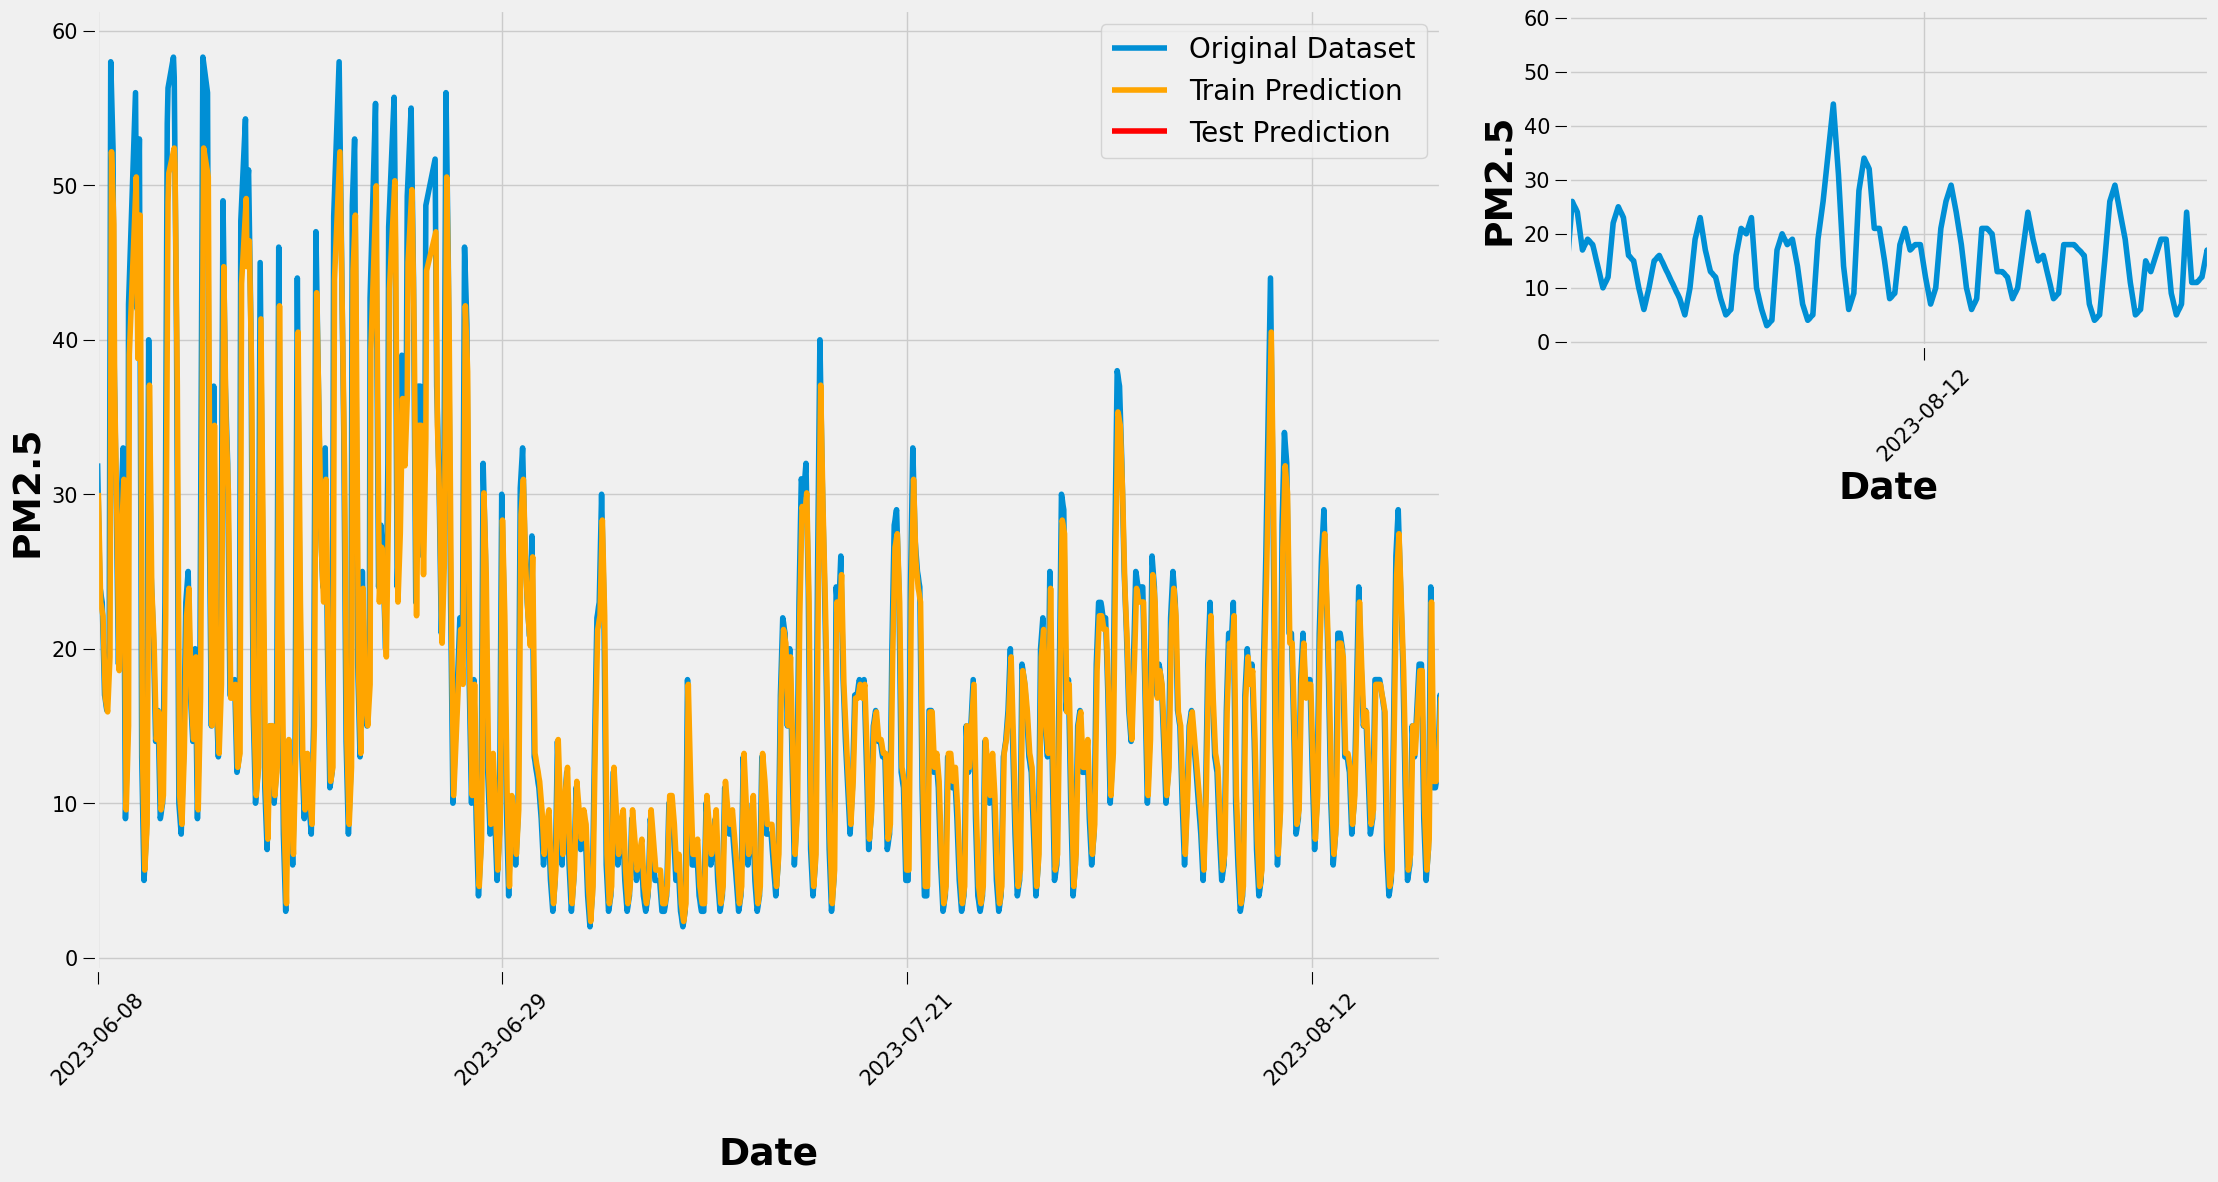

In [73]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot original dataset and predictions
time_axis = np.linspace(0, dataset.shape[0]-1, 15)
time_axis = np.array([int(i) for i in time_axis])
time_axisLab = np.array(data.index, dtype='datetime64[D]')

fig = plt.figure()
ax = fig.add_axes([0, 0, 2.1, 2])
ax.plot(np.expm1(dataset), label='Original Dataset')
ax.plot(trainPredictPlot, color='orange', label='Train Prediction')
ax.plot(testPredictPlot, color='red', label='Test Prediction')
ax.set_xticks(time_axis)
ax.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax.set_xlabel('\nDate', fontsize=27, fontweight='bold')
ax.set_ylabel('PM2.5', fontsize=27, fontweight='bold')
ax.legend(loc='best', prop= {'size':20})
ax.tick_params(size=10, labelsize=15)
ax.set_xlim([-1,1735])

ax1 = fig.add_axes([2.3, 1.3, 1, 0.7])
ax1.plot(np.expm1(dataset), label='Original Dataset')
ax1.plot(testPredictPlot, color='red', label='Test Prediction')
ax1.set_xticks(time_axis)
ax1.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax1.set_xlabel('Date', fontsize=27, fontweight='bold')
ax1.set_ylabel('PM2.5', fontsize=27, fontweight='bold')
ax1.tick_params(size=10, labelsize=15)
ax1.set_xlim([1360,1735]);

In [45]:
testPredictPlot.shape

(7321, 1)

# 3. Temperature prediction

In [10]:
dataset = np.log1p(data[['Temperature']].values)
dataset.shape

(7323, 1)

<Figure size 1200x500 with 0 Axes>

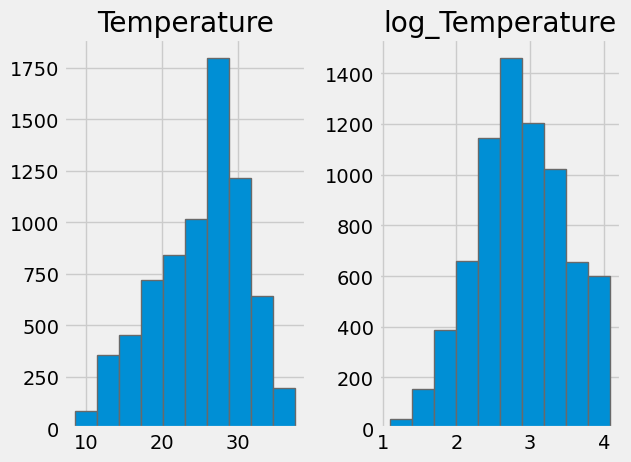

In [74]:
# create new dataframe to compare the original vs log transform data
dist_df = pd.DataFrame({'Temperature' : data['Temperature'].values, 'log_Temperature' : dataset[:,0]})

# histogram plot original vs log transform data
plt.figure(figsize=(12,5))
dist_df.hist();

In [12]:
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

5492 1831


In [32]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print('Shape of trainX :', trainX.shape)
print('Shape of trainY :', trainY.shape)
print('Shape of testX :', testX.shape)
print('Shape of testY :', testY.shape)

Shape of trainX : (5490, 1)
Shape of trainY : (5490,)
Shape of testX : (1829, 1)
Shape of testY : (1829,)


In [33]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print('Shape of trainX :', trainX.shape)
print('Shape of testX :', testX.shape)

Shape of trainX : (5490, 1, 1)
Shape of testX : (1829, 1, 1)


In [34]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1500, batch_size=32, verbose=2)

2024-06-23 08:56:14.012899: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


Epoch 1/1500
172/172 - 1s - 7ms/step - loss: 8.6106
Epoch 2/1500
172/172 - 0s - 1ms/step - loss: 4.1029
Epoch 3/1500
172/172 - 0s - 1ms/step - loss: 1.4097
Epoch 4/1500
172/172 - 0s - 1ms/step - loss: 0.4279
Epoch 5/1500
172/172 - 0s - 1ms/step - loss: 0.1313
Epoch 6/1500
172/172 - 0s - 1ms/step - loss: 0.0579
Epoch 7/1500
172/172 - 0s - 1ms/step - loss: 0.0435
Epoch 8/1500
172/172 - 0s - 1ms/step - loss: 0.0410
Epoch 9/1500
172/172 - 0s - 1ms/step - loss: 0.0405
Epoch 10/1500
172/172 - 0s - 1ms/step - loss: 0.0401
Epoch 11/1500
172/172 - 0s - 1ms/step - loss: 0.0397
Epoch 12/1500
172/172 - 0s - 1ms/step - loss: 0.0392
Epoch 13/1500
172/172 - 0s - 1ms/step - loss: 0.0386
Epoch 14/1500
172/172 - 0s - 2ms/step - loss: 0.0374
Epoch 15/1500
172/172 - 0s - 2ms/step - loss: 0.0336
Epoch 16/1500
172/172 - 0s - 1ms/step - loss: 0.0292
Epoch 17/1500
172/172 - 0s - 1ms/step - loss: 0.0253
Epoch 18/1500
172/172 - 0s - 1ms/step - loss: 0.0220
Epoch 19/1500
172/172 - 0s - 1ms/step - loss: 0.0189
Ep

## Model Performance

In [36]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = np.expm1(trainPredict)
trainY = np.expm1(trainY)
testPredict = np.expm1(testPredict)
testY = np.expm1(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step
Train Score: 998732909499804.62 RMSE
Test Score: 349528734323257.62 RMSE


In [37]:
test_series = pd.Series(testY)

# state of model performance
if testScore < test_series.std():
    print('\n[ Model performance is GOOD enough ]')
    print('\nRMSE of test prediction < Standard deviation of test dataset')
    print('%.2f' % (testScore), '<', '%.2f' % (test_series.std()))
else:
    print('\n[ Model performance is NOT GOOD enough ]')
    print('\nRMSE of test prediction > Standard deviation of test dataset')
    print('%.2f' % (testScore), '>', '%.2f' % (test_series.std()))


[ Model performance is NOT GOOD enough ]

RMSE of test prediction > Standard deviation of test dataset
349528734323257.62 > 345597894022965.06


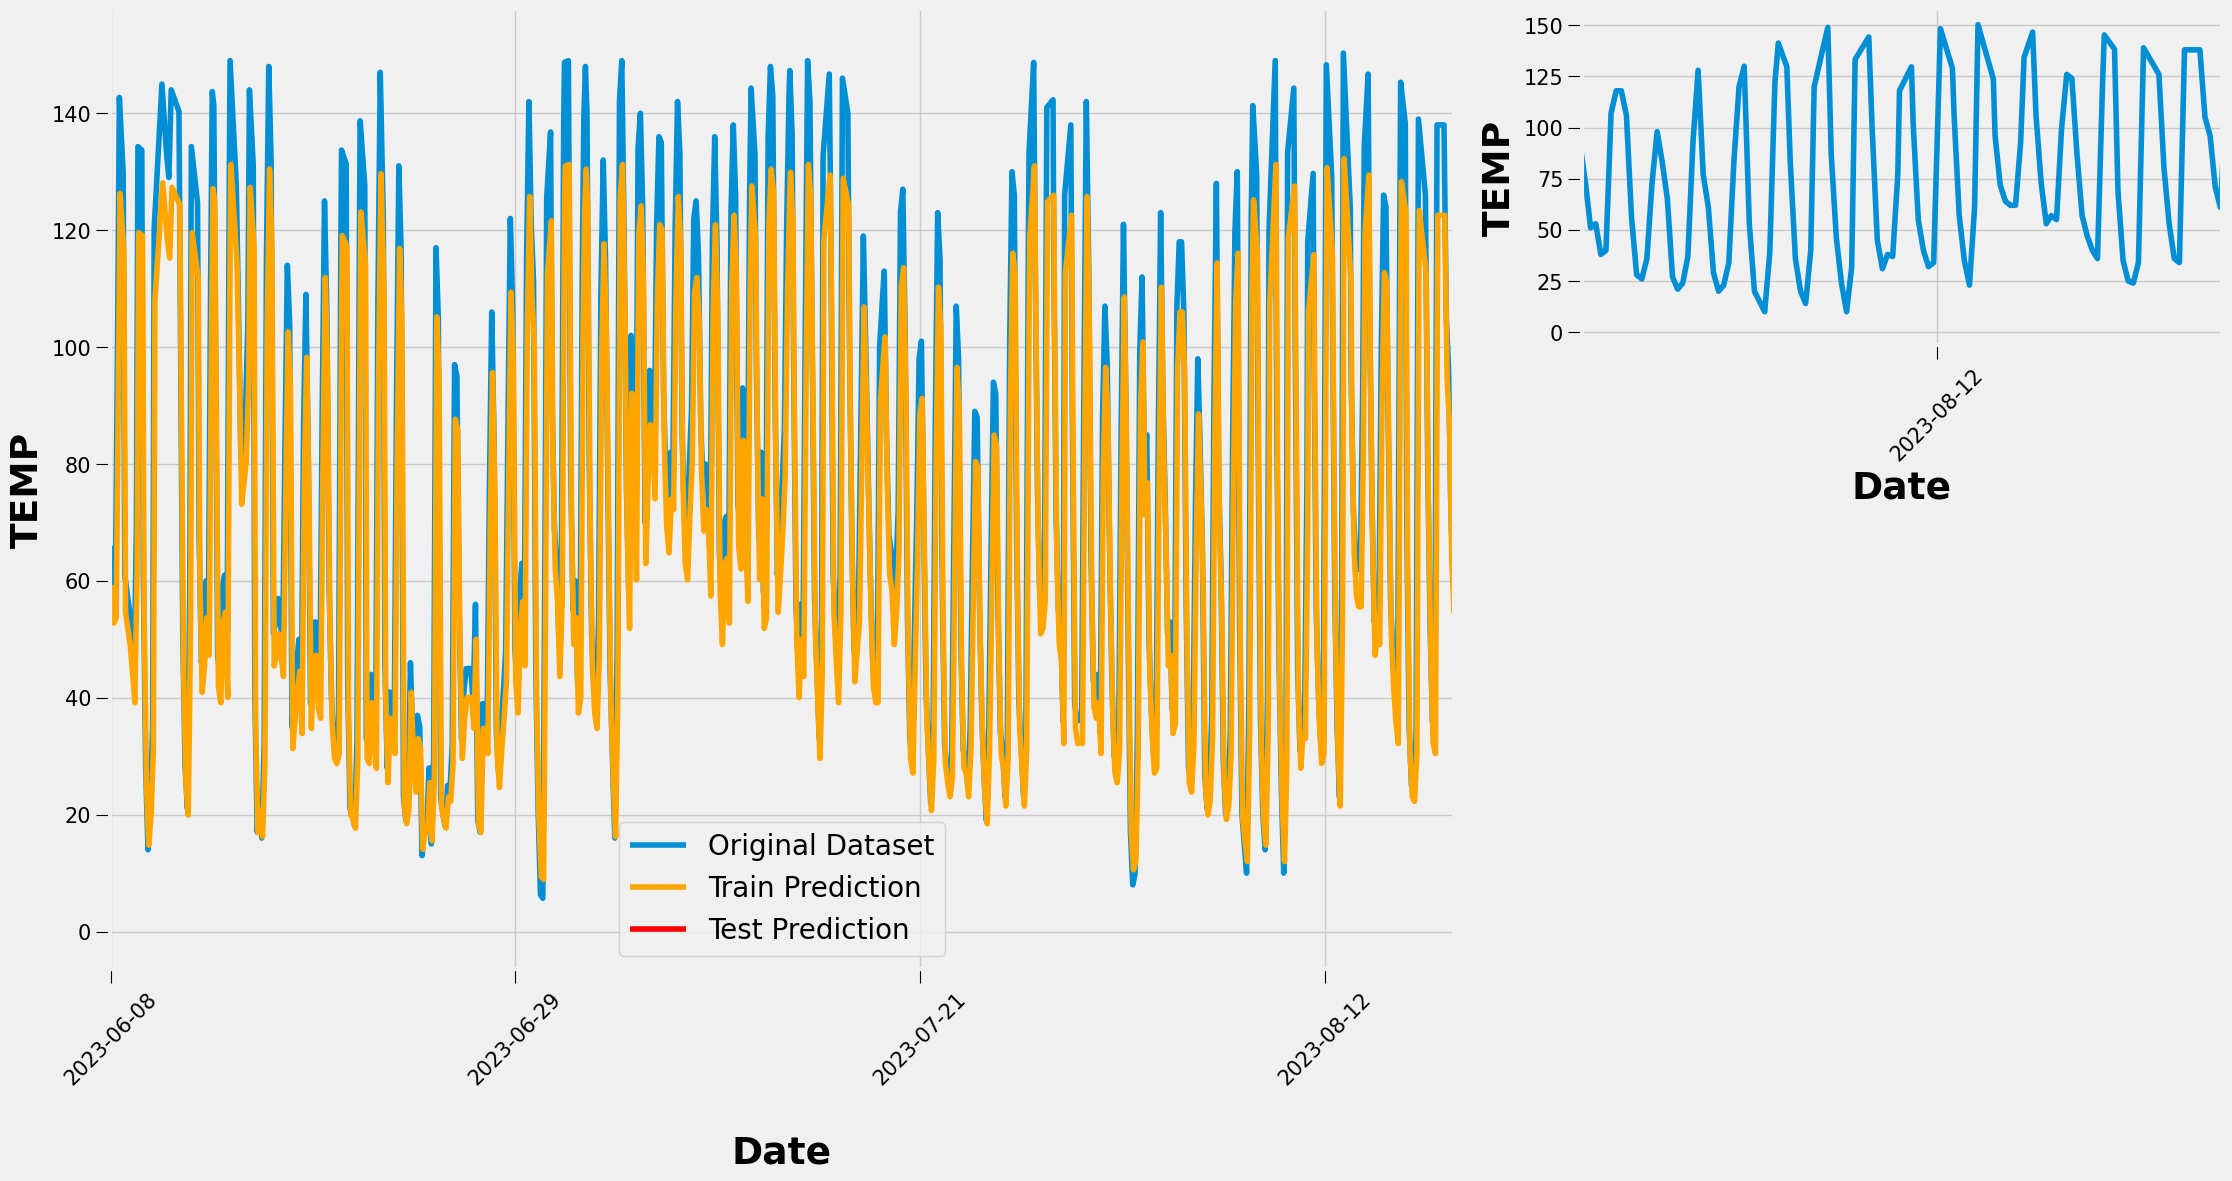

In [89]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot original dataset and predictions
time_axis = np.linspace(0, dataset.shape[0]-1, 15)
time_axis = np.array([int(i) for i in time_axis])
time_axisLab = np.array(data.index, dtype='datetime64[D]')

fig = plt.figure()
ax = fig.add_axes([0, 0, 2.1, 2])
ax.plot(np.expm1(dataset), label='Original Dataset')
ax.plot(trainPredictPlot, color='orange', label='Train Prediction')
ax.plot(testPredictPlot, color='red', label='Test Prediction')
ax.set_xticks(time_axis)
ax.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax.set_xlabel('\nDate', fontsize=27, fontweight='bold')
ax.set_ylabel('TEMP', fontsize=27, fontweight='bold')
ax.legend(loc='best', prop= {'size':20})
ax.tick_params(size=10, labelsize=15)
ax.set_xlim([-1,1735])

ax1 = fig.add_axes([2.3, 1.3, 1, 0.7])
ax1.plot(np.expm1(dataset), label='Original Dataset')
ax1.plot(testPredictPlot, color='red', label='Test Prediction')
ax1.set_xticks(time_axis)
ax1.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax1.set_xlabel('Date', fontsize=27, fontweight='bold')
ax1.set_ylabel('TEMP', fontsize=27, fontweight='bold')
ax1.tick_params(size=10, labelsize=15)
ax1.set_xlim([1360,1735]);

## 4. NO2 Prediction

In [39]:
dataset = np.log1p(data[['NO2']].values)
dataset.shape

(7321, 1)

<Figure size 1200x500 with 0 Axes>

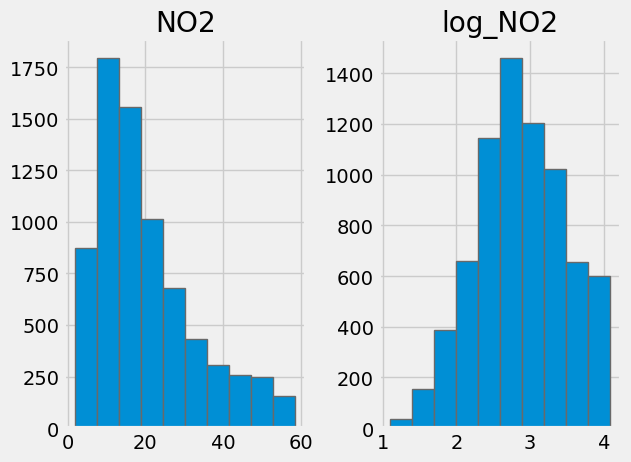

In [41]:
# create new dataframe to compare the original vs log transform data
dist_df = pd.DataFrame({'NO2' : data['NO2'].values, 'log_NO2' : dataset[:,0]})

# histogram plot original vs log transform data
plt.figure(figsize=(12,5))
dist_df.hist();

In [42]:
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

5490 1831


In [43]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print('Shape of trainX :', trainX.shape)
print('Shape of trainY :', trainY.shape)
print('Shape of testX :', testX.shape)
print('Shape of testY :', testY.shape)

Shape of trainX : (5488, 1)
Shape of trainY : (5488,)
Shape of testX : (1829, 1)
Shape of testY : (1829,)


In [48]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print('Shape of trainX :', trainX.shape)
print('Shape of testX :', testX.shape)

Shape of trainX : (5488, 1, 1)
Shape of testX : (1829, 1, 1)


In [49]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1000, batch_size=32, verbose=2)

Epoch 1/1000
172/172 - 1s - 5ms/step - loss: 6.2089
Epoch 2/1000
172/172 - 0s - 1ms/step - loss: 3.0122
Epoch 3/1000
172/172 - 0s - 1ms/step - loss: 0.9185
Epoch 4/1000
172/172 - 0s - 1ms/step - loss: 0.2754
Epoch 5/1000
172/172 - 0s - 1ms/step - loss: 0.1736
Epoch 6/1000
172/172 - 0s - 1ms/step - loss: 0.1600
Epoch 7/1000
172/172 - 0s - 1ms/step - loss: 0.1540
Epoch 8/1000
172/172 - 0s - 1ms/step - loss: 0.1470
Epoch 9/1000
172/172 - 0s - 1ms/step - loss: 0.1384
Epoch 10/1000
172/172 - 0s - 1ms/step - loss: 0.1271
Epoch 11/1000
172/172 - 0s - 2ms/step - loss: 0.1143
Epoch 12/1000
172/172 - 0s - 1ms/step - loss: 0.1017
Epoch 13/1000
172/172 - 0s - 1ms/step - loss: 0.0910
Epoch 14/1000
172/172 - 0s - 1ms/step - loss: 0.0830
Epoch 15/1000
172/172 - 0s - 1ms/step - loss: 0.0781
Epoch 16/1000
172/172 - 0s - 1ms/step - loss: 0.0739
Epoch 17/1000
172/172 - 0s - 1ms/step - loss: 0.0718
Epoch 18/1000
172/172 - 0s - 1ms/step - loss: 0.0703
Epoch 19/1000
172/172 - 0s - 2ms/step - loss: 0.0695
Ep

## Model Performance

In [50]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = np.expm1(trainPredict)
trainY = np.expm1(trainY)
testPredict = np.expm1(testPredict)
testY = np.expm1(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step
Train Score: 5.27 RMSE
Test Score: 10.24 RMSE


In [51]:
test_series = pd.Series(testY)

# state of model performance
if testScore < test_series.std():
    print('\n[ Model performance is GOOD enough ]')
    print('\nRMSE of test prediction < Standard deviation of test dataset')
    print('%.2f' % (testScore), '<', '%.2f' % (test_series.std()))
else:
    print('\n[ Model performance is NOT GOOD enough ]')
    print('\nRMSE of test prediction > Standard deviation of test dataset')
    print('%.2f' % (testScore), '>', '%.2f' % (test_series.std()))


[ Model performance is GOOD enough ]

RMSE of test prediction < Standard deviation of test dataset
10.24 < 13.71


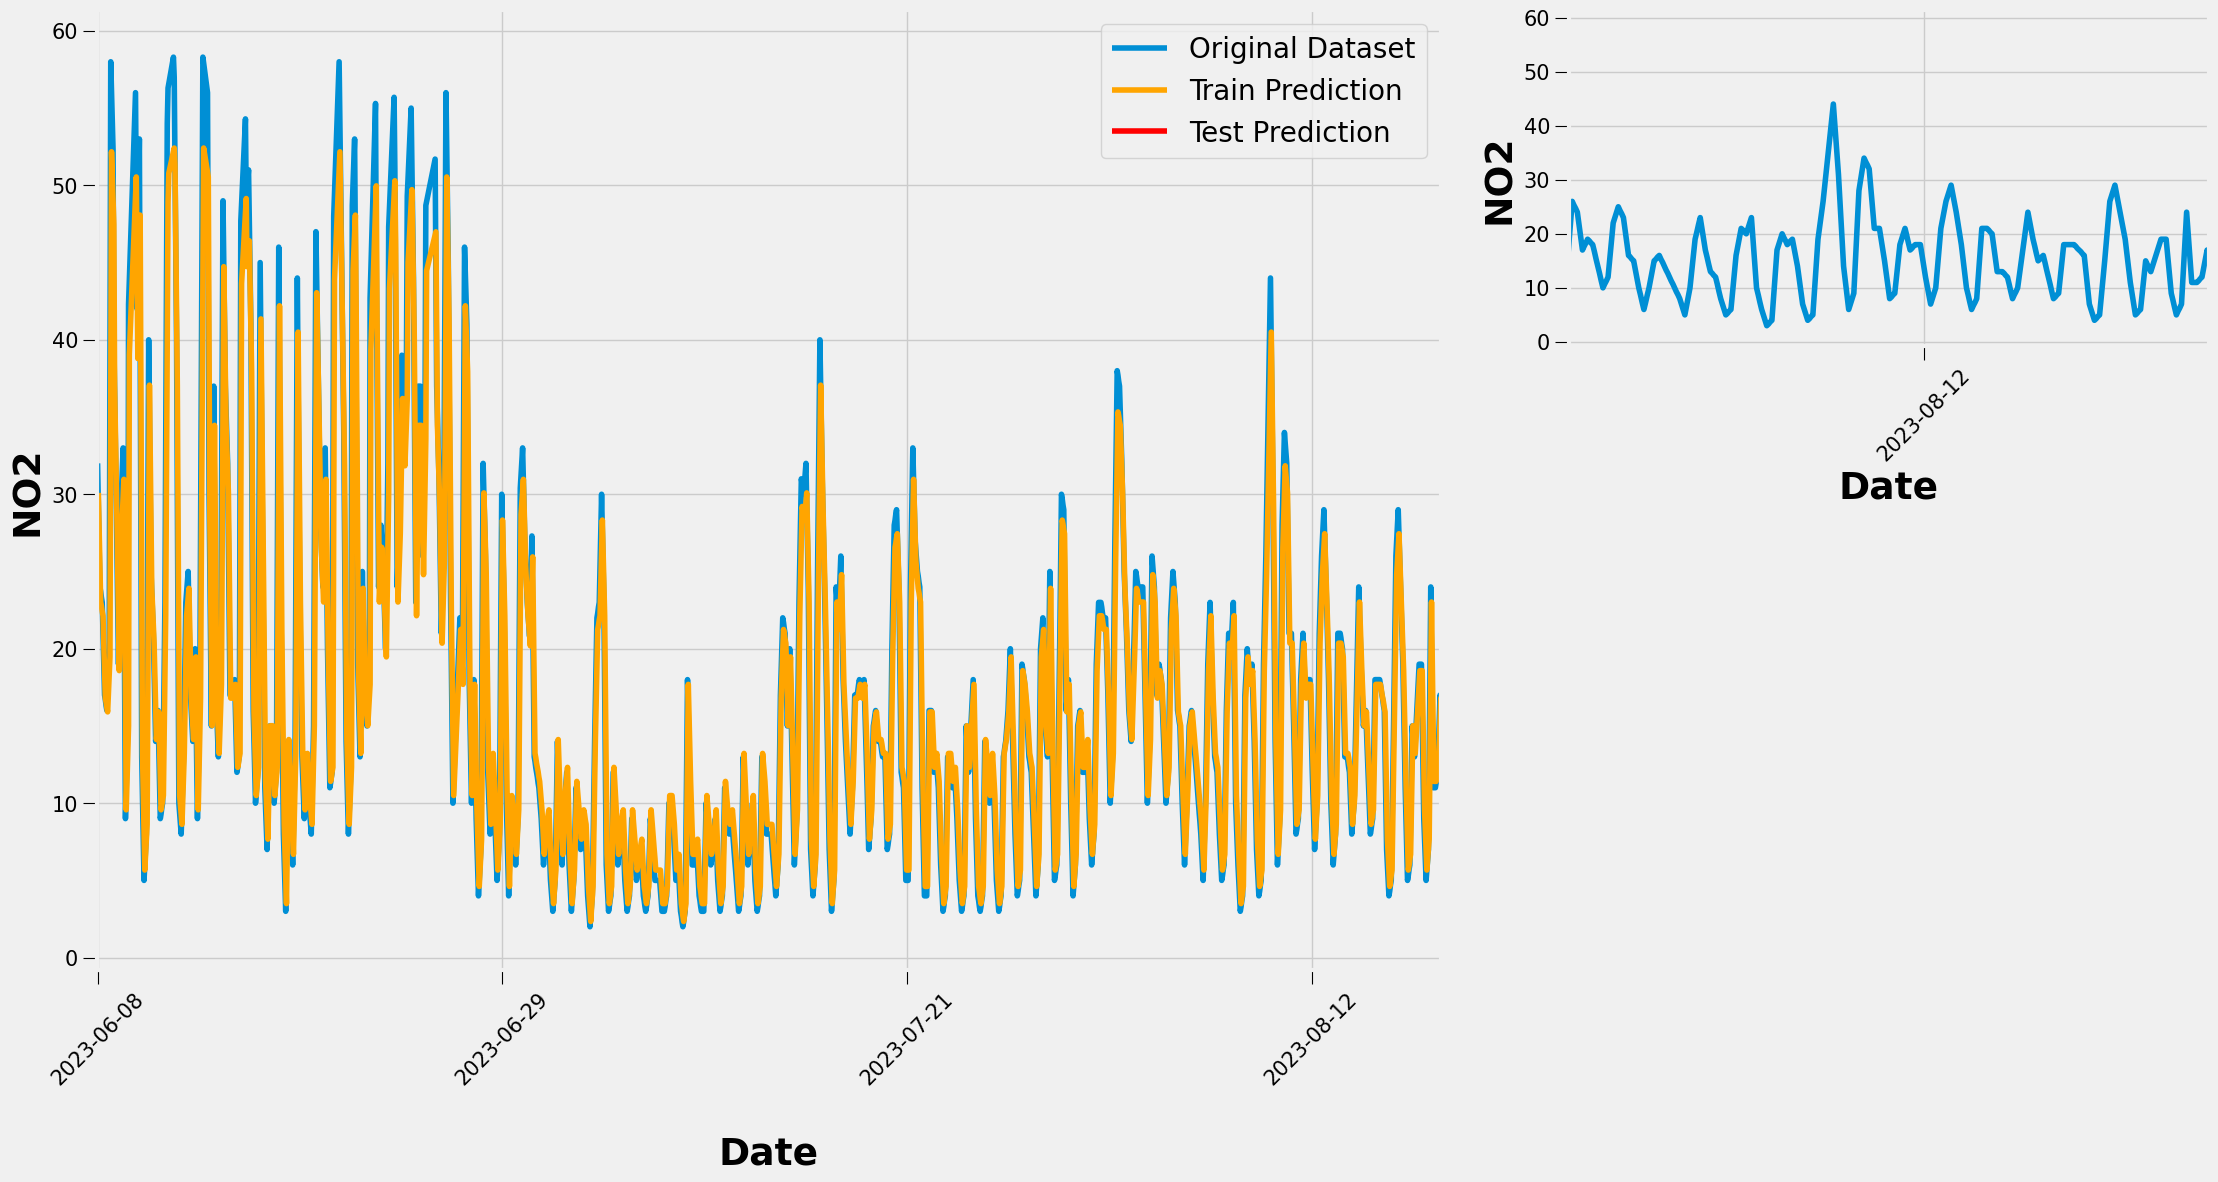

In [52]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot original dataset and predictions
time_axis = np.linspace(0, dataset.shape[0]-1, 15)
time_axis = np.array([int(i) for i in time_axis])
time_axisLab = np.array(data.index, dtype='datetime64[D]')

fig = plt.figure()
ax = fig.add_axes([0, 0, 2.1, 2])
ax.plot(np.expm1(dataset), label='Original Dataset')
ax.plot(trainPredictPlot, color='orange', label='Train Prediction')
ax.plot(testPredictPlot, color='red', label='Test Prediction')
ax.set_xticks(time_axis)
ax.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax.set_xlabel('\nDate', fontsize=27, fontweight='bold')
ax.set_ylabel('NO2', fontsize=27, fontweight='bold')
ax.legend(loc='best', prop= {'size':20})
ax.tick_params(size=10, labelsize=15)
ax.set_xlim([-1,1735])

ax1 = fig.add_axes([2.3, 1.3, 1, 0.7])
ax1.plot(np.expm1(dataset), label='Original Dataset')
ax1.plot(testPredictPlot, color='red', label='Test Prediction')
ax1.set_xticks(time_axis)
ax1.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax1.set_xlabel('Date', fontsize=27, fontweight='bold')
ax1.set_ylabel('NO2', fontsize=27, fontweight='bold')
ax1.tick_params(size=10, labelsize=15)
ax1.set_xlim([1360,1735]);

## 5. O3 Prediction

In [75]:
dataset = np.log1p(data[['O3']].values)
dataset.shape

(7321, 1)

<Figure size 1200x500 with 0 Axes>

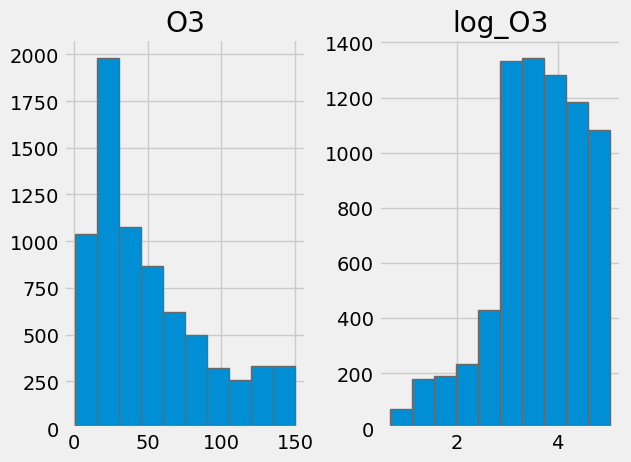

In [76]:
# create new dataframe to compare the original vs log transform data
dist_df = pd.DataFrame({'O3' : data['O3'].values, 'log_O3' : dataset[:,0]})

# histogram plot original vs log transform data
plt.figure(figsize=(12,5))
dist_df.hist();

In [77]:
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

5490 1831


In [78]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print('Shape of trainX :', trainX.shape)
print('Shape of trainY :', trainY.shape)
print('Shape of testX :', testX.shape)
print('Shape of testY :', testY.shape)

Shape of trainX : (5488, 1)
Shape of trainY : (5488,)
Shape of testX : (1829, 1)
Shape of testY : (1829,)


In [79]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print('Shape of trainX :', trainX.shape)
print('Shape of testX :', testX.shape)

Shape of trainX : (5488, 1, 1)
Shape of testX : (1829, 1, 1)


In [88]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1000, batch_size=32, verbose=2)

Epoch 1/1000
172/172 - 1s - 5ms/step - loss: nan
Epoch 2/1000
172/172 - 0s - 1ms/step - loss: nan
Epoch 3/1000
172/172 - 0s - 1ms/step - loss: nan
Epoch 4/1000
172/172 - 0s - 931us/step - loss: nan
Epoch 5/1000
172/172 - 0s - 895us/step - loss: nan
Epoch 6/1000
172/172 - 0s - 969us/step - loss: nan
Epoch 7/1000
172/172 - 0s - 834us/step - loss: nan
Epoch 8/1000
172/172 - 0s - 842us/step - loss: nan
Epoch 9/1000
172/172 - 0s - 1ms/step - loss: nan
Epoch 10/1000
172/172 - 0s - 1ms/step - loss: nan
Epoch 11/1000
172/172 - 0s - 1ms/step - loss: nan
Epoch 12/1000
172/172 - 0s - 1ms/step - loss: nan
Epoch 13/1000
172/172 - 0s - 1ms/step - loss: nan
Epoch 14/1000
172/172 - 0s - 1ms/step - loss: nan
Epoch 15/1000
172/172 - 0s - 973us/step - loss: nan
Epoch 16/1000
172/172 - 0s - 951us/step - loss: nan
Epoch 17/1000
172/172 - 0s - 1ms/step - loss: nan
Epoch 18/1000
172/172 - 0s - 1ms/step - loss: nan
Epoch 19/1000
172/172 - 0s - 916us/step - loss: nan
Epoch 20/1000
172/172 - 0s - 2ms/step - los

## Model Performance

In [90]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = np.expm1(trainPredict)
trainY = np.expm1(trainY)
testPredict = np.expm1(testPredict)
testY = np.expm1(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step


ValueError: Input contains infinity or a value too large for dtype('float64').

In [86]:
test_series = pd.Series(testY)

# state of model performance
if testScore < test_series.std():
    print('\n[ Model performance is GOOD enough ]')
    print('\nRMSE of test prediction < Standard deviation of test dataset')
    print('%.2f' % (testScore), '<', '%.2f' % (test_series.std()))
else:
    print('\n[ Model performance is NOT GOOD enough ]')
    print('\nRMSE of test prediction > Standard deviation of test dataset')
    print('%.2f' % (testScore), '>', '%.2f' % (test_series.std()))


[ Model performance is NOT GOOD enough ]

RMSE of test prediction > Standard deviation of test dataset
3674430032753156346460489661471414332321719011446616736776847360.00 > nan


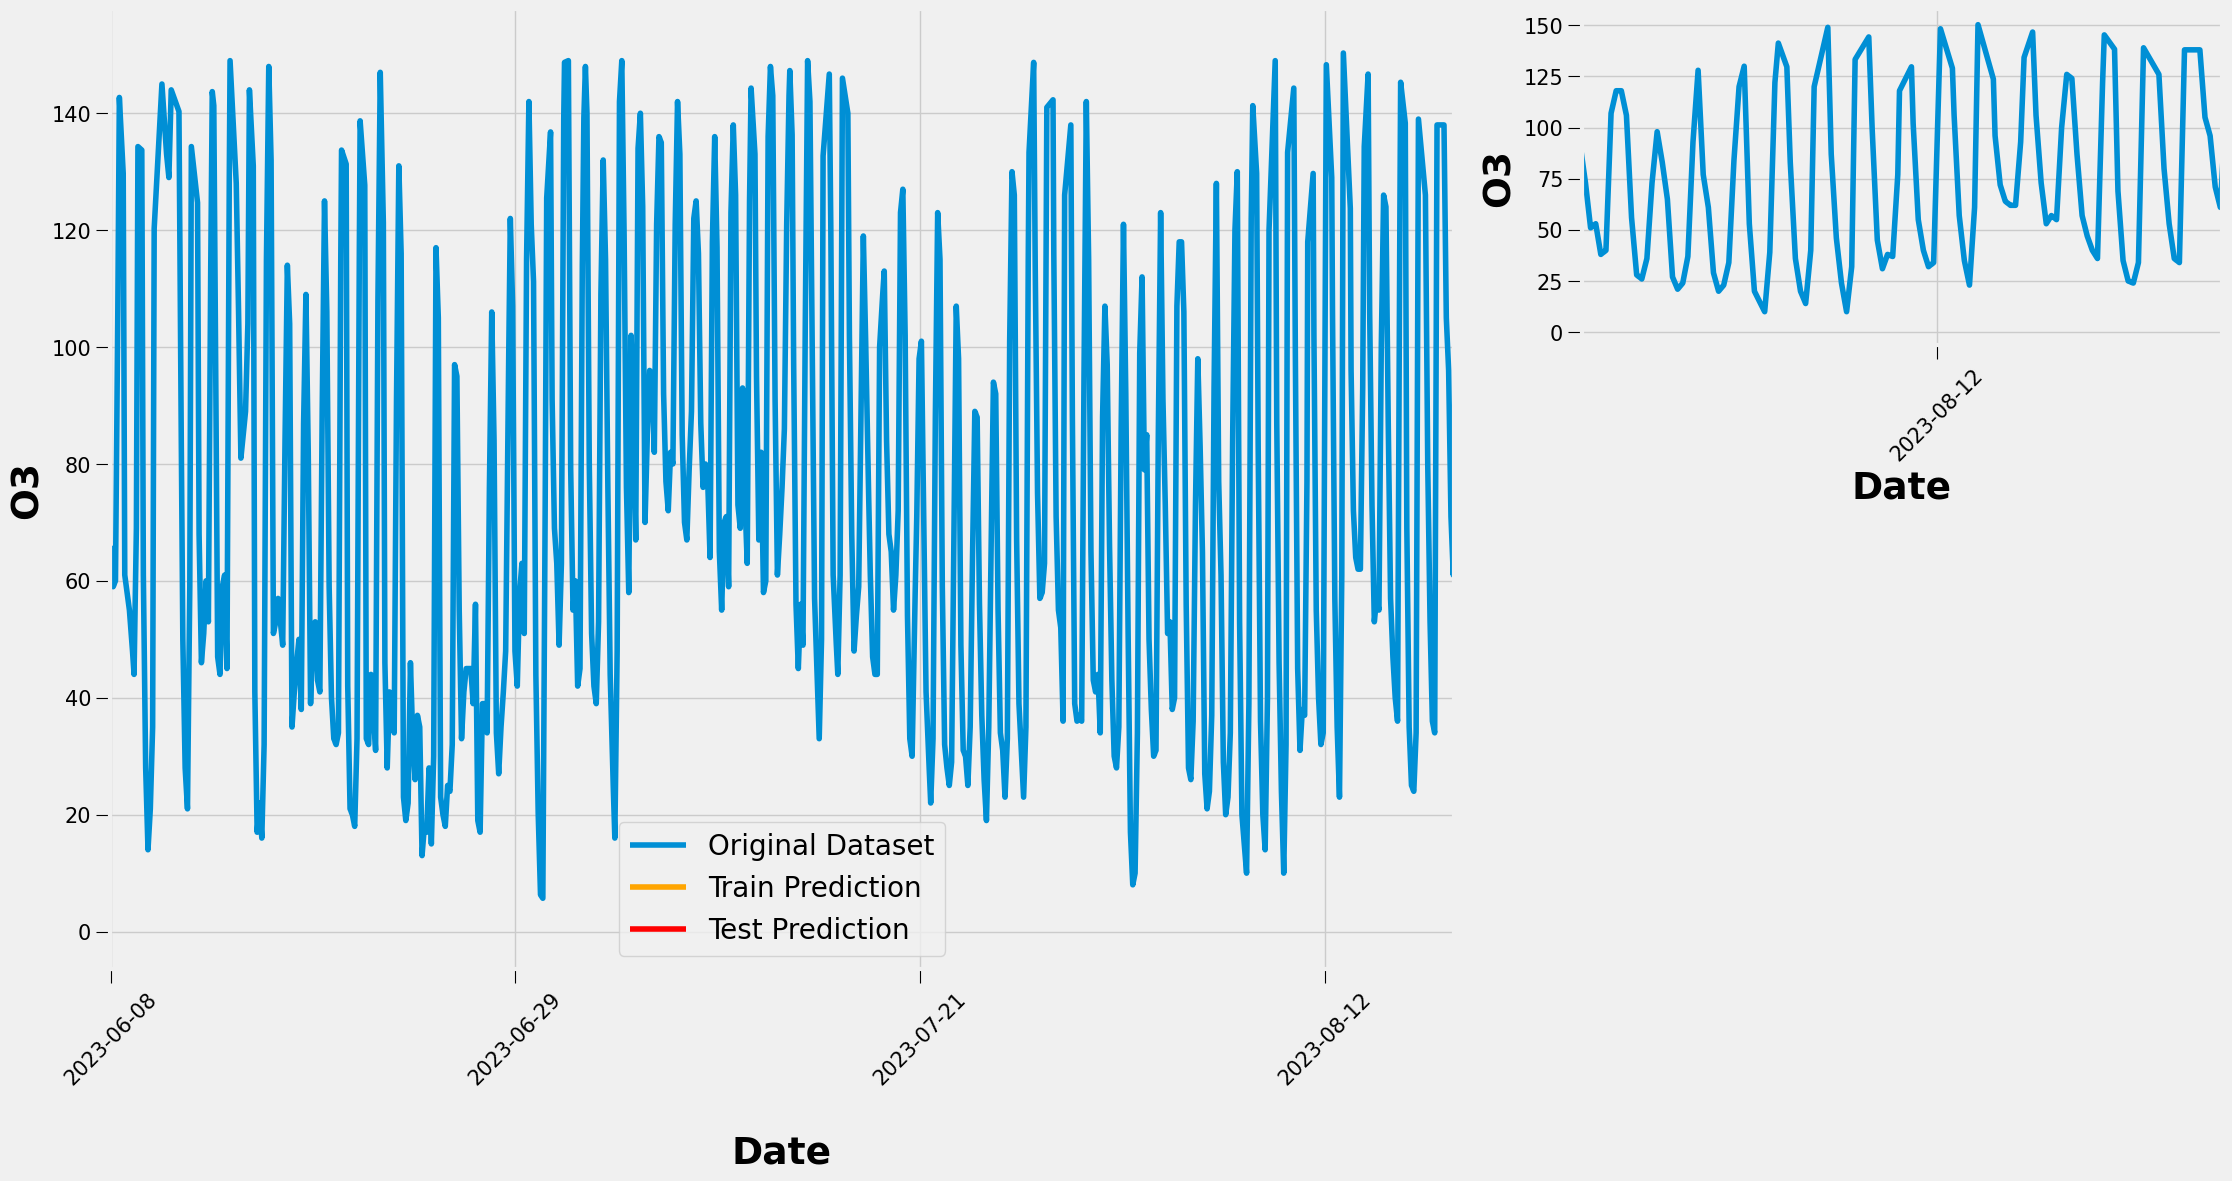

In [91]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot original dataset and predictions
time_axis = np.linspace(0, dataset.shape[0]-1, 15)
time_axis = np.array([int(i) for i in time_axis])
time_axisLab = np.array(data.index, dtype='datetime64[D]')

fig = plt.figure()
ax = fig.add_axes([0, 0, 2.1, 2])
ax.plot(np.expm1(dataset), label='Original Dataset')
ax.plot(trainPredictPlot, color='orange', label='Train Prediction')
ax.plot(testPredictPlot, color='red', label='Test Prediction')
ax.set_xticks(time_axis)
ax.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax.set_xlabel('\nDate', fontsize=27, fontweight='bold')
ax.set_ylabel('O3', fontsize=27, fontweight='bold')
ax.legend(loc='best', prop= {'size':20})
ax.tick_params(size=10, labelsize=15)
ax.set_xlim([-1,1735])

ax1 = fig.add_axes([2.3, 1.3, 1, 0.7])
ax1.plot(np.expm1(dataset), label='Original Dataset')
ax1.plot(testPredictPlot, color='red', label='Test Prediction')
ax1.set_xticks(time_axis)
ax1.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax1.set_xlabel('Date', fontsize=27, fontweight='bold')
ax1.set_ylabel('O3', fontsize=27, fontweight='bold')
ax1.tick_params(size=10, labelsize=15)
ax1.set_xlim([1360,1735]);

## 6. PM10 Prediction

In [92]:
dataset = np.log1p(data[['PM10']].values)
dataset.shape

(7321, 1)

<Figure size 1200x500 with 0 Axes>

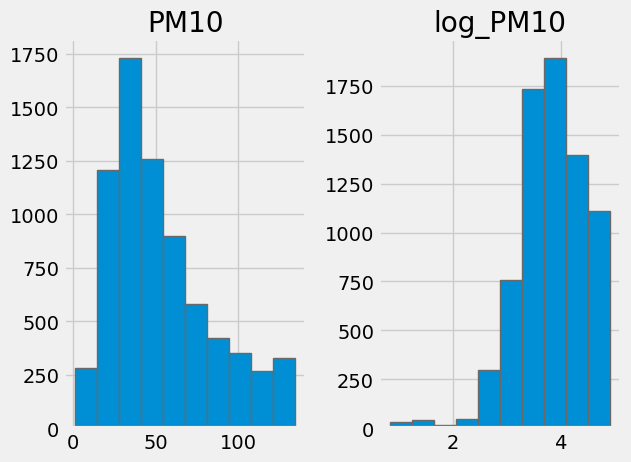

In [93]:
# create new dataframe to compare the original vs log transform data
dist_df = pd.DataFrame({'PM10' : data['PM10'].values, 'log_PM10' : dataset[:,0]})

# histogram plot original vs log transform data
plt.figure(figsize=(12,5))
dist_df.hist();

In [94]:
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

5490 1831


In [95]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print('Shape of trainX :', trainX.shape)
print('Shape of trainY :', trainY.shape)
print('Shape of testX :', testX.shape)
print('Shape of testY :', testY.shape)

Shape of trainX : (5488, 1)
Shape of trainY : (5488,)
Shape of testX : (1829, 1)
Shape of testY : (1829,)


In [123]:
trainX

array([[[nan]],

       [[nan]],

       [[nan]],

       ...,

       [[ 0.]],

       [[ 0.]],

       [[ 0.]]])

In [96]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print('Shape of trainX :', trainX.shape)
print('Shape of testX :', testX.shape)

Shape of trainX : (5488, 1, 1)
Shape of testX : (1829, 1, 1)


In [97]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1000, batch_size=32, verbose=2)

Epoch 1/1000
172/172 - 1s - 5ms/step - loss: 11.2608
Epoch 2/1000
172/172 - 0s - 1ms/step - loss: 6.4627
Epoch 3/1000
172/172 - 0s - 1ms/step - loss: 2.9406
Epoch 4/1000
172/172 - 0s - 1ms/step - loss: 1.1714
Epoch 5/1000
172/172 - 0s - 916us/step - loss: 0.4751
Epoch 6/1000
172/172 - 0s - 1ms/step - loss: 0.2873
Epoch 7/1000
172/172 - 0s - 983us/step - loss: 0.2463
Epoch 8/1000
172/172 - 0s - 1ms/step - loss: 0.2263
Epoch 9/1000
172/172 - 0s - 1ms/step - loss: 0.1906
Epoch 10/1000
172/172 - 0s - 1ms/step - loss: 0.1624
Epoch 11/1000
172/172 - 0s - 1ms/step - loss: 0.1416
Epoch 12/1000
172/172 - 0s - 1ms/step - loss: 0.1267
Epoch 13/1000
172/172 - 0s - 1ms/step - loss: 0.1153
Epoch 14/1000
172/172 - 0s - 1ms/step - loss: 0.1076
Epoch 15/1000
172/172 - 0s - 949us/step - loss: 0.1016
Epoch 16/1000
172/172 - 0s - 1ms/step - loss: 0.0974
Epoch 17/1000
172/172 - 0s - 2ms/step - loss: 0.0947
Epoch 18/1000
172/172 - 0s - 1ms/step - loss: 0.0927
Epoch 19/1000
172/172 - 0s - 1ms/step - loss: 0.

## Model Performance

In [98]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = np.expm1(trainPredict)
trainY = np.expm1(trainY)
testPredict = np.expm1(testPredict)
testY = np.expm1(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step
Train Score: 14.59 RMSE
Test Score: 17.96 RMSE


In [99]:
test_series = pd.Series(testY)

# state of model performance
if testScore < test_series.std():
    print('\n[ Model performance is GOOD enough ]')
    print('\nRMSE of test prediction < Standard deviation of test dataset')
    print('%.2f' % (testScore), '<', '%.2f' % (test_series.std()))
else:
    print('\n[ Model performance is NOT GOOD enough ]')
    print('\nRMSE of test prediction > Standard deviation of test dataset')
    print('%.2f' % (testScore), '>', '%.2f' % (test_series.std()))


[ Model performance is GOOD enough ]

RMSE of test prediction < Standard deviation of test dataset
17.96 < 29.34


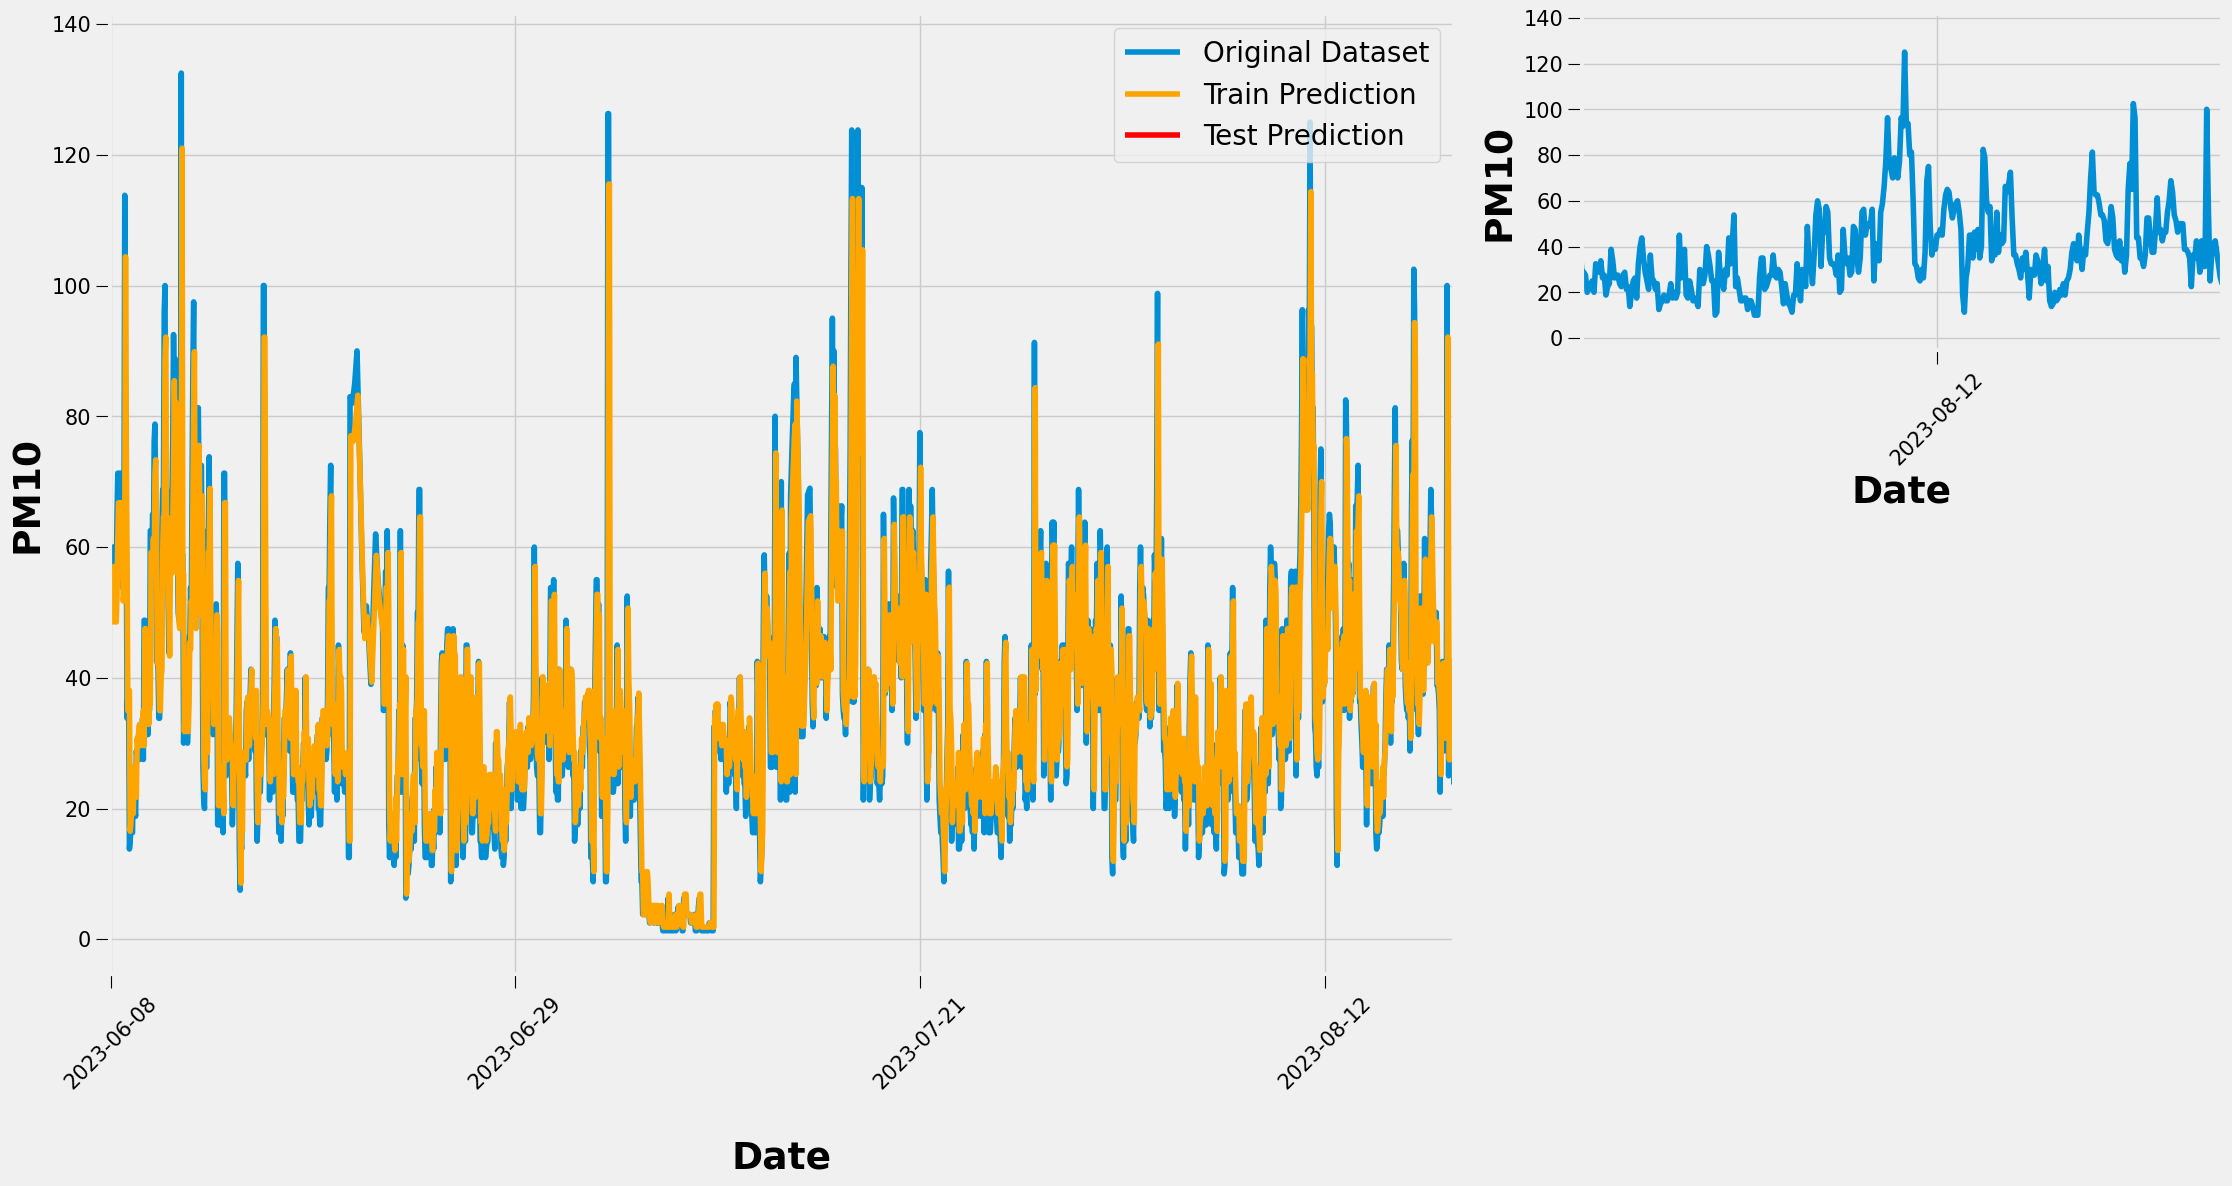

In [100]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot original dataset and predictions
time_axis = np.linspace(0, dataset.shape[0]-1, 15)
time_axis = np.array([int(i) for i in time_axis])
time_axisLab = np.array(data.index, dtype='datetime64[D]')

fig = plt.figure()
ax = fig.add_axes([0, 0, 2.1, 2])
ax.plot(np.expm1(dataset), label='Original Dataset')
ax.plot(trainPredictPlot, color='orange', label='Train Prediction')
ax.plot(testPredictPlot, color='red', label='Test Prediction')
ax.set_xticks(time_axis)
ax.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax.set_xlabel('\nDate', fontsize=27, fontweight='bold')
ax.set_ylabel('PM10', fontsize=27, fontweight='bold')
ax.legend(loc='best', prop= {'size':20})
ax.tick_params(size=10, labelsize=15)
ax.set_xlim([-1,1735])

ax1 = fig.add_axes([2.3, 1.3, 1, 0.7])
ax1.plot(np.expm1(dataset), label='Original Dataset')
ax1.plot(testPredictPlot, color='red', label='Test Prediction')
ax1.set_xticks(time_axis)
ax1.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax1.set_xlabel('Date', fontsize=27, fontweight='bold')
ax1.set_ylabel('PM10', fontsize=27, fontweight='bold')
ax1.tick_params(size=10, labelsize=15)
ax1.set_xlim([1360,1735]);

## 7. Precipitation Prediction

In [103]:
dataset = np.log1p(data[['Precipitation']].values)
dataset.shape

(7321, 1)

<Figure size 1200x500 with 0 Axes>

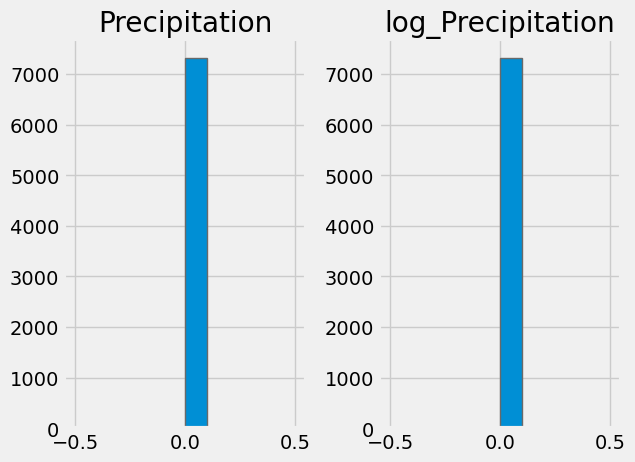

In [104]:
# create new dataframe to compare the original vs log transform data
dist_df = pd.DataFrame({'Precipitation' : data['Precipitation'].values, 'log_Precipitation' : dataset[:,0]})

# histogram plot original vs log transform data
plt.figure(figsize=(12,5))
dist_df.hist();

In [119]:
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

5490 1831


In [116]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print('Shape of trainX :', trainX.shape)
print('Shape of trainY :', trainY.shape)
print('Shape of testX :', testX.shape)
print('Shape of testY :', testY.shape)

Shape of trainX : (5488, 1)
Shape of trainY : (5488,)
Shape of testX : (1829, 1)
Shape of testY : (1829,)


In [121]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print('Shape of trainX :', trainX.shape)
print('Shape of testX :', testX.shape)

Shape of trainX : (5488, 1, 1)
Shape of testX : (1829, 1, 1)


In [122]:
trainX

array([[[nan]],

       [[nan]],

       [[nan]],

       ...,

       [[ 0.]],

       [[ 0.]],

       [[ 0.]]])

In [124]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1000, batch_size=32, verbose=2)

Epoch 1/1000
172/172 - 1s - 6ms/step - loss: nan
Epoch 2/1000
172/172 - 0s - 2ms/step - loss: nan
Epoch 3/1000
172/172 - 0s - 902us/step - loss: nan
Epoch 4/1000
172/172 - 0s - 857us/step - loss: nan
Epoch 5/1000
172/172 - 0s - 848us/step - loss: nan
Epoch 6/1000
172/172 - 0s - 815us/step - loss: nan
Epoch 7/1000
172/172 - 0s - 936us/step - loss: nan
Epoch 8/1000
172/172 - 0s - 959us/step - loss: nan
Epoch 9/1000
172/172 - 0s - 1ms/step - loss: nan
Epoch 10/1000
172/172 - 0s - 970us/step - loss: nan
Epoch 11/1000
172/172 - 0s - 1ms/step - loss: nan
Epoch 12/1000
172/172 - 0s - 1ms/step - loss: nan
Epoch 13/1000
172/172 - 0s - 854us/step - loss: nan
Epoch 14/1000
172/172 - 0s - 907us/step - loss: nan
Epoch 15/1000
172/172 - 0s - 971us/step - loss: nan
Epoch 16/1000
172/172 - 0s - 940us/step - loss: nan
Epoch 17/1000
172/172 - 0s - 1ms/step - loss: nan
Epoch 18/1000
172/172 - 0s - 954us/step - loss: nan
Epoch 19/1000
172/172 - 0s - 915us/step - loss: nan
Epoch 20/1000
172/172 - 0s - 1ms/

## Model Performance

In [109]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = np.expm1(trainPredict)
trainY = np.expm1(trainY)
testPredict = np.expm1(testPredict)
testY = np.expm1(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step


ValueError: Input contains NaN.

In [112]:
test_series = pd.Series(testY)

# state of model performance
if testScore < test_series.std():
    print('\n[ Model performance is GOOD enough ]')
    print('\nRMSE of test prediction < Standard deviation of test dataset')
    print('%.2f' % (testScore), '<', '%.2f' % (test_series.std()))
else:
    print('\n[ Model performance is NOT GOOD enough ]')
    print('\nRMSE of test prediction > Standard deviation of test dataset')
    print('%.2f' % (testScore), '>', '%.2f' % (test_series.std()))


[ Model performance is NOT GOOD enough ]

RMSE of test prediction > Standard deviation of test dataset
17.96 > 0.00


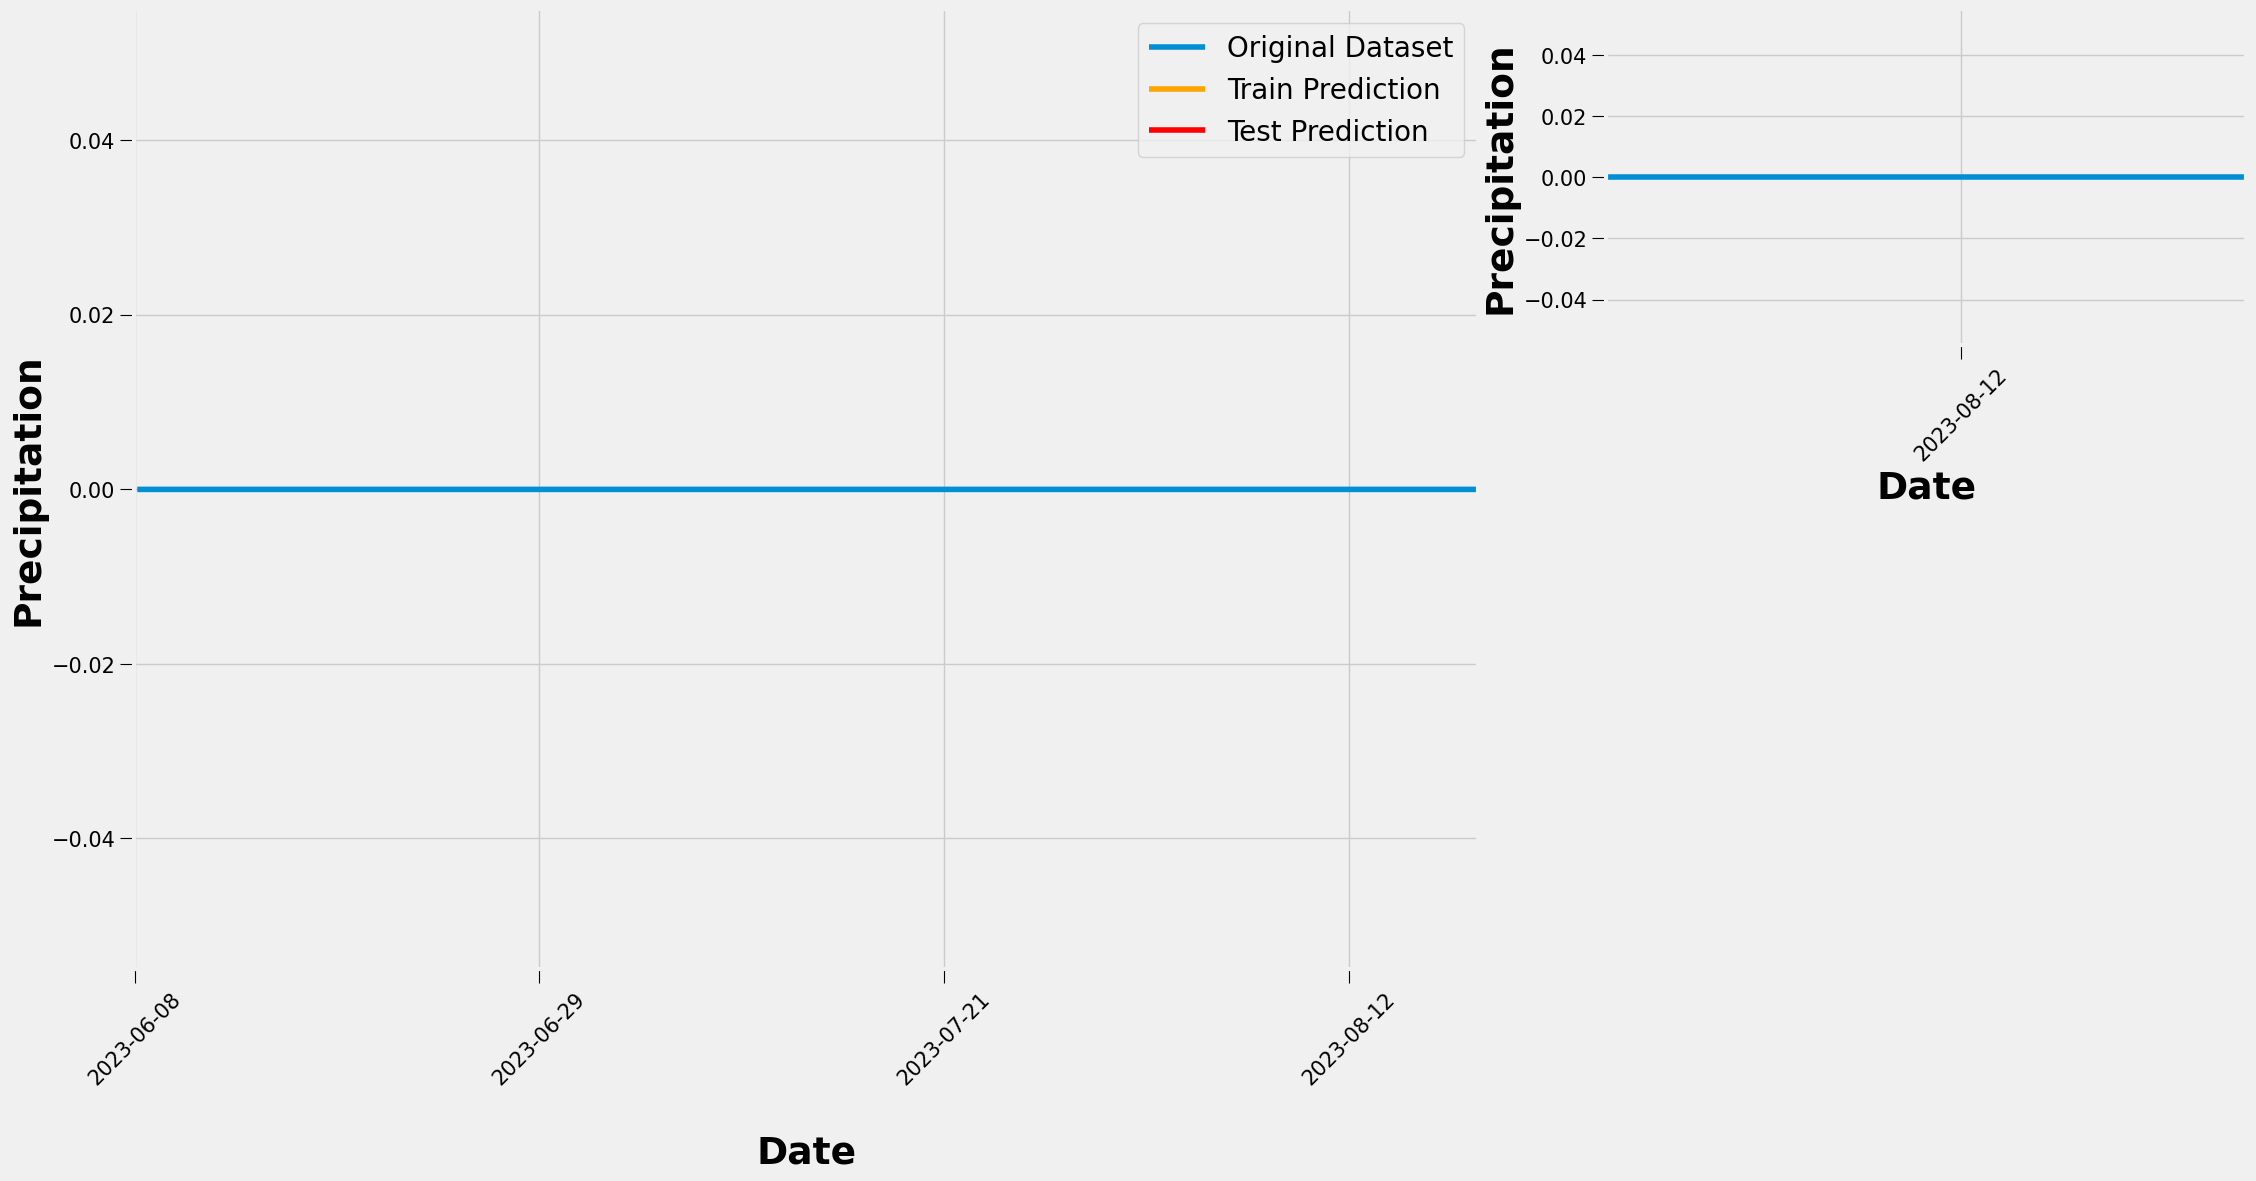

In [113]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot original dataset and predictions
time_axis = np.linspace(0, dataset.shape[0]-1, 15)
time_axis = np.array([int(i) for i in time_axis])
time_axisLab = np.array(data.index, dtype='datetime64[D]')

fig = plt.figure()
ax = fig.add_axes([0, 0, 2.1, 2])
ax.plot(np.expm1(dataset), label='Original Dataset')
ax.plot(trainPredictPlot, color='orange', label='Train Prediction')
ax.plot(testPredictPlot, color='red', label='Test Prediction')
ax.set_xticks(time_axis)
ax.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax.set_xlabel('\nDate', fontsize=27, fontweight='bold')
ax.set_ylabel('Precipitation', fontsize=27, fontweight='bold')
ax.legend(loc='best', prop= {'size':20})
ax.tick_params(size=10, labelsize=15)
ax.set_xlim([-1,1735])

ax1 = fig.add_axes([2.3, 1.3, 1, 0.7])
ax1.plot(np.expm1(dataset), label='Original Dataset')
ax1.plot(testPredictPlot, color='red', label='Test Prediction')
ax1.set_xticks(time_axis)
ax1.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax1.set_xlabel('Date', fontsize=27, fontweight='bold')
ax1.set_ylabel('Precipitation', fontsize=27, fontweight='bold')
ax1.tick_params(size=10, labelsize=15)
ax1.set_xlim([1360,1735]);

## 8. Pressure Prediction

In [127]:
dataset = np.log1p(data[['Pressure']].values)
dataset.shape

(7321, 1)

<Figure size 1200x500 with 0 Axes>

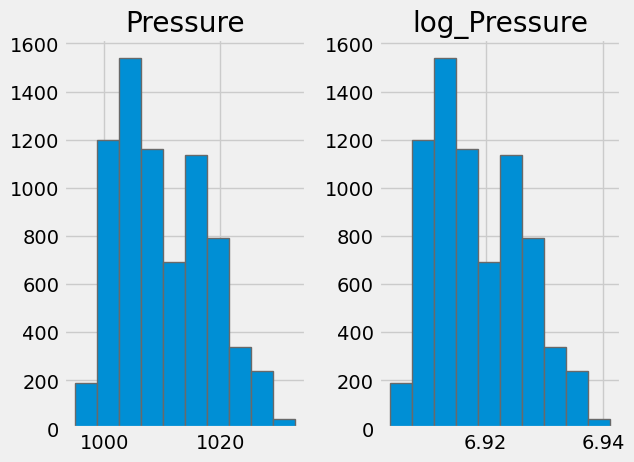

In [128]:
# create new dataframe to compare the original vs log transform data
dist_df = pd.DataFrame({'Pressure' : data['Pressure'].values, 'log_Pressure' : dataset[:,0]})

# histogram plot original vs log transform data
plt.figure(figsize=(12,5))
dist_df.hist();

In [129]:
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

5490 1831


In [130]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print('Shape of trainX :', trainX.shape)
print('Shape of trainY :', trainY.shape)
print('Shape of testX :', testX.shape)
print('Shape of testY :', testY.shape)

Shape of trainX : (5488, 1)
Shape of trainY : (5488,)
Shape of testX : (1829, 1)
Shape of testY : (1829,)


In [131]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print('Shape of trainX :', trainX.shape)
print('Shape of testX :', testX.shape)

Shape of trainX : (5488, 1, 1)
Shape of testX : (1829, 1, 1)


In [132]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1000, batch_size=32, verbose=2)

Epoch 1/1000
172/172 - 1s - 5ms/step - loss: 38.2550
Epoch 2/1000
172/172 - 0s - 1ms/step - loss: 25.6996
Epoch 3/1000
172/172 - 0s - 985us/step - loss: 16.6234
Epoch 4/1000
172/172 - 0s - 963us/step - loss: 11.2072
Epoch 5/1000
172/172 - 0s - 912us/step - loss: 7.5385
Epoch 6/1000
172/172 - 0s - 902us/step - loss: 4.9675
Epoch 7/1000
172/172 - 0s - 955us/step - loss: 3.1754
Epoch 8/1000
172/172 - 0s - 972us/step - loss: 1.9548
Epoch 9/1000
172/172 - 0s - 982us/step - loss: 1.1512
Epoch 10/1000
172/172 - 0s - 1ms/step - loss: 0.6444
Epoch 11/1000
172/172 - 0s - 1ms/step - loss: 0.3407
Epoch 12/1000
172/172 - 0s - 1ms/step - loss: 0.1689
Epoch 13/1000
172/172 - 0s - 1ms/step - loss: 0.0781
Epoch 14/1000
172/172 - 0s - 1ms/step - loss: 0.0334
Epoch 15/1000
172/172 - 0s - 1ms/step - loss: 0.0131
Epoch 16/1000
172/172 - 0s - 1ms/step - loss: 0.0047
Epoch 17/1000
172/172 - 0s - 1ms/step - loss: 0.0016
Epoch 18/1000
172/172 - 0s - 1ms/step - loss: 4.9921e-04
Epoch 19/1000
172/172 - 0s - 1ms/

## Model Performance

In [133]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = np.expm1(trainPredict)
trainY = np.expm1(trainY)
testPredict = np.expm1(testPredict)
testY = np.expm1(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step
Train Score: 1.80 RMSE
Test Score: 1.37 RMSE


In [134]:
test_series = pd.Series(testY)

# state of model performance
if testScore < test_series.std():
    print('\n[ Model performance is GOOD enough ]')
    print('\nRMSE of test prediction < Standard deviation of test dataset')
    print('%.2f' % (testScore), '<', '%.2f' % (test_series.std()))
else:
    print('\n[ Model performance is NOT GOOD enough ]')
    print('\nRMSE of test prediction > Standard deviation of test dataset')
    print('%.2f' % (testScore), '>', '%.2f' % (test_series.std()))


[ Model performance is GOOD enough ]

RMSE of test prediction < Standard deviation of test dataset
1.37 < 5.89


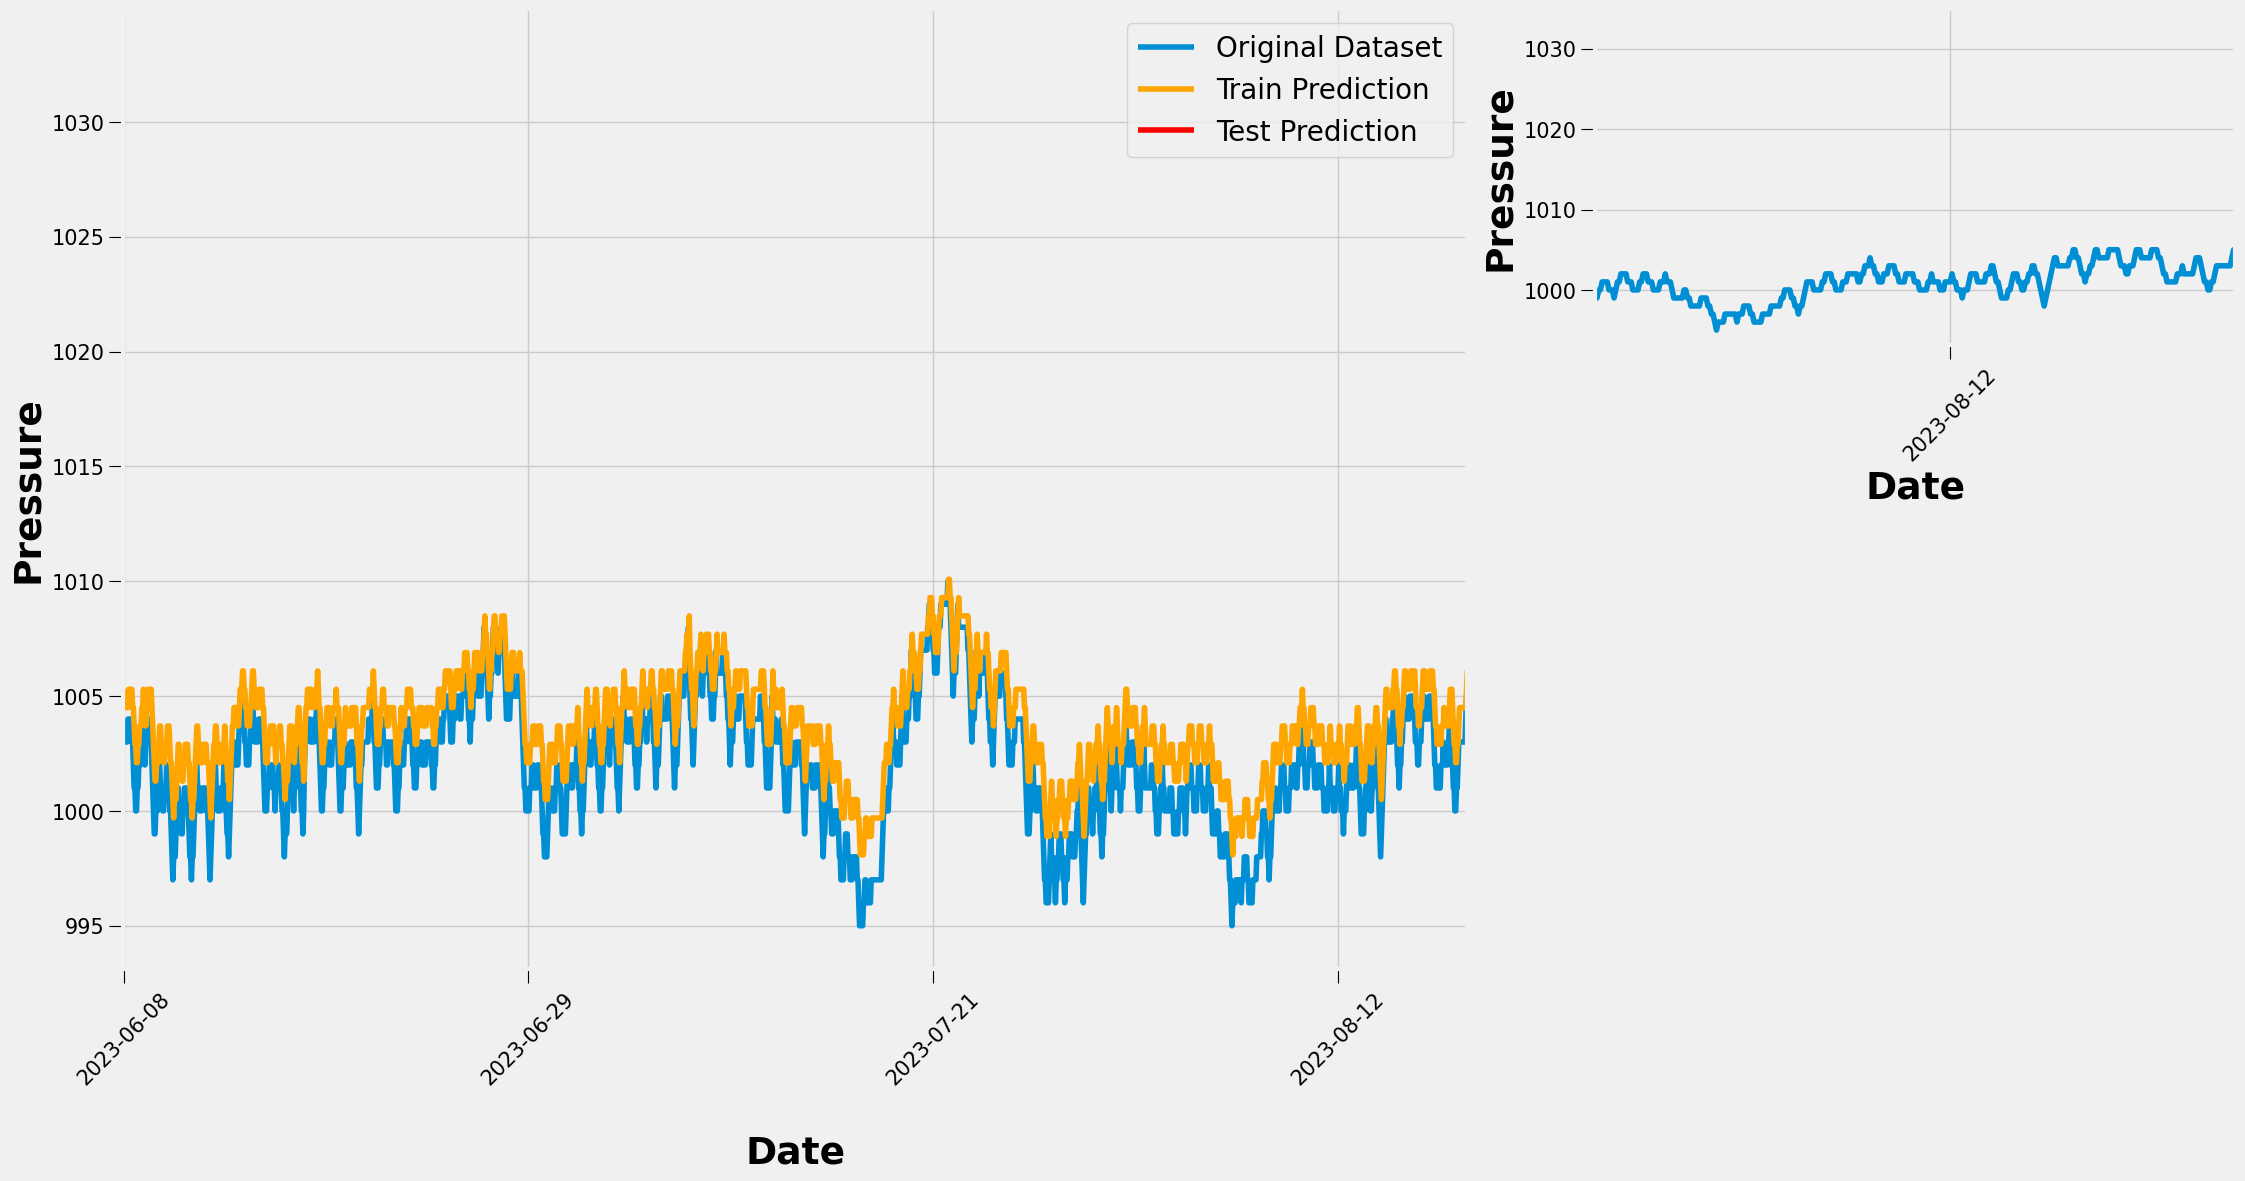

In [135]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot original dataset and predictions
time_axis = np.linspace(0, dataset.shape[0]-1, 15)
time_axis = np.array([int(i) for i in time_axis])
time_axisLab = np.array(data.index, dtype='datetime64[D]')

fig = plt.figure()
ax = fig.add_axes([0, 0, 2.1, 2])
ax.plot(np.expm1(dataset), label='Original Dataset')
ax.plot(trainPredictPlot, color='orange', label='Train Prediction')
ax.plot(testPredictPlot, color='red', label='Test Prediction')
ax.set_xticks(time_axis)
ax.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax.set_xlabel('\nDate', fontsize=27, fontweight='bold')
ax.set_ylabel('Pressure', fontsize=27, fontweight='bold')
ax.legend(loc='best', prop= {'size':20})
ax.tick_params(size=10, labelsize=15)
ax.set_xlim([-1,1735])

ax1 = fig.add_axes([2.3, 1.3, 1, 0.7])
ax1.plot(np.expm1(dataset), label='Original Dataset')
ax1.plot(testPredictPlot, color='red', label='Test Prediction')
ax1.set_xticks(time_axis)
ax1.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax1.set_xlabel('Date', fontsize=27, fontweight='bold')
ax1.set_ylabel('Pressure', fontsize=27, fontweight='bold')
ax1.tick_params(size=10, labelsize=15)
ax1.set_xlim([1360,1735]);

## 9. Relative Humidity	Temperature Prediction

In [140]:
dataset = np.log1p(data[['Relative Humidity']].values)
dataset.shape

(7321, 1)

<Figure size 1200x500 with 0 Axes>

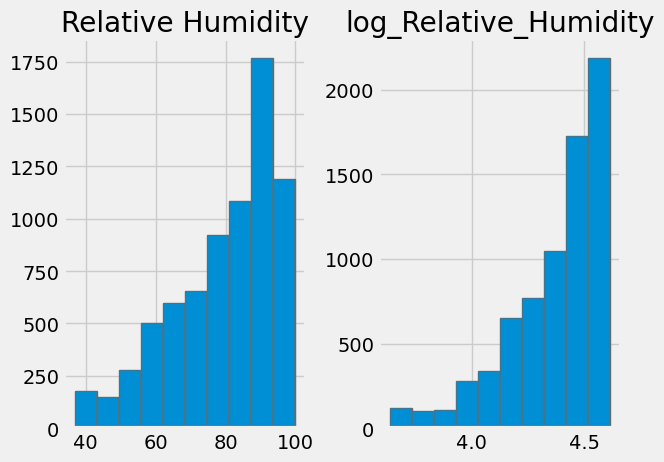

In [141]:
# create new dataframe to compare the original vs log transform data
dist_df = pd.DataFrame({'Relative Humidity' : data['Relative Humidity'].values, 'log_Relative_Humidity' : dataset[:,0]})

# histogram plot original vs log transform data
plt.figure(figsize=(12,5))
dist_df.hist();

In [142]:
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

5490 1831


In [143]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print('Shape of trainX :', trainX.shape)
print('Shape of trainY :', trainY.shape)
print('Shape of testX :', testX.shape)
print('Shape of testY :', testY.shape)

Shape of trainX : (5488, 1)
Shape of trainY : (5488,)
Shape of testX : (1829, 1)
Shape of testY : (1829,)


In [144]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print('Shape of trainX :', trainX.shape)
print('Shape of testX :', testX.shape)

Shape of trainX : (5488, 1, 1)
Shape of testX : (1829, 1, 1)


In [145]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1000, batch_size=32, verbose=2)

Epoch 1/1000
172/172 - 1s - 7ms/step - loss: 12.8311
Epoch 2/1000
172/172 - 1s - 3ms/step - loss: 6.6088
Epoch 3/1000
172/172 - 0s - 1ms/step - loss: 2.7184
Epoch 4/1000
172/172 - 0s - 1ms/step - loss: 1.0096
Epoch 5/1000
172/172 - 0s - 1ms/step - loss: 0.3535
Epoch 6/1000
172/172 - 0s - 1ms/step - loss: 0.1252
Epoch 7/1000
172/172 - 0s - 2ms/step - loss: 0.0566
Epoch 8/1000
172/172 - 0s - 1ms/step - loss: 0.0393
Epoch 9/1000
172/172 - 0s - 1ms/step - loss: 0.0357
Epoch 10/1000
172/172 - 0s - 2ms/step - loss: 0.0350
Epoch 11/1000
172/172 - 0s - 1ms/step - loss: 0.0349
Epoch 12/1000
172/172 - 0s - 1ms/step - loss: 0.0347
Epoch 13/1000
172/172 - 0s - 1ms/step - loss: 0.0347
Epoch 14/1000
172/172 - 0s - 975us/step - loss: 0.0345
Epoch 15/1000
172/172 - 0s - 1ms/step - loss: 0.0344
Epoch 16/1000
172/172 - 0s - 1ms/step - loss: 0.0342
Epoch 17/1000
172/172 - 0s - 1ms/step - loss: 0.0341
Epoch 18/1000
172/172 - 0s - 992us/step - loss: 0.0339
Epoch 19/1000
172/172 - 0s - 1ms/step - loss: 0.03

## Model Performance

In [146]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = np.expm1(trainPredict)
trainY = np.expm1(trainY)
testPredict = np.expm1(testPredict)
testY = np.expm1(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Train Score: 3.83 RMSE
Test Score: 3.31 RMSE


In [147]:
test_series = pd.Series(testY)

# state of model performance
if testScore < test_series.std():
    print('\n[ Model performance is GOOD enough ]')
    print('\nRMSE of test prediction < Standard deviation of test dataset')
    print('%.2f' % (testScore), '<', '%.2f' % (test_series.std()))
else:
    print('\n[ Model performance is NOT GOOD enough ]')
    print('\nRMSE of test prediction > Standard deviation of test dataset')
    print('%.2f' % (testScore), '>', '%.2f' % (test_series.std()))


[ Model performance is GOOD enough ]

RMSE of test prediction < Standard deviation of test dataset
3.31 < 11.62


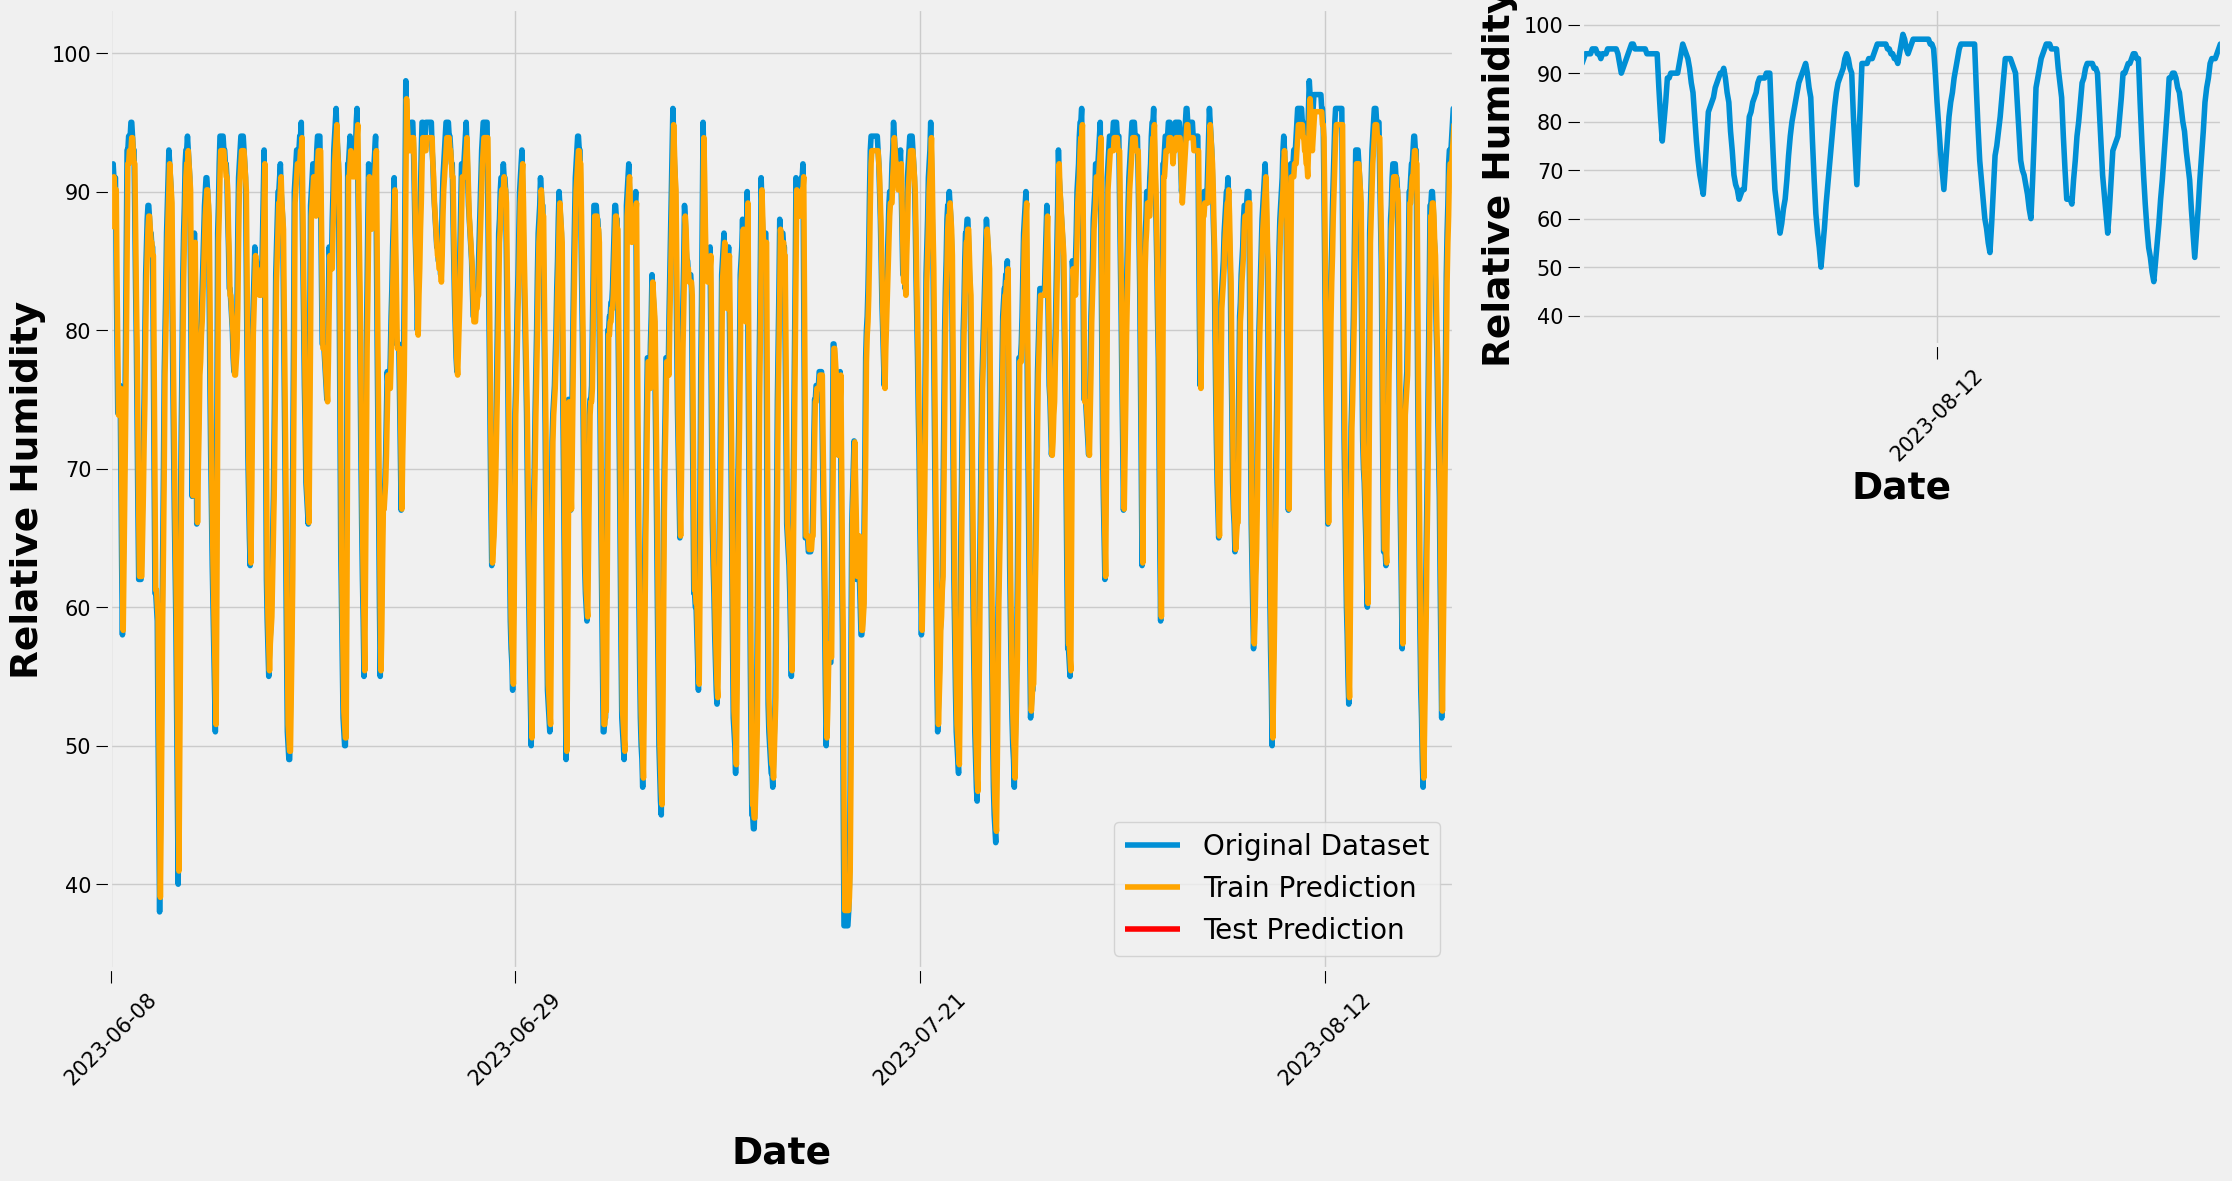

In [148]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot original dataset and predictions
time_axis = np.linspace(0, dataset.shape[0]-1, 15)
time_axis = np.array([int(i) for i in time_axis])
time_axisLab = np.array(data.index, dtype='datetime64[D]')

fig = plt.figure()
ax = fig.add_axes([0, 0, 2.1, 2])
ax.plot(np.expm1(dataset), label='Original Dataset')
ax.plot(trainPredictPlot, color='orange', label='Train Prediction')
ax.plot(testPredictPlot, color='red', label='Test Prediction')
ax.set_xticks(time_axis)
ax.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax.set_xlabel('\nDate', fontsize=27, fontweight='bold')
ax.set_ylabel('Relative Humidity', fontsize=27, fontweight='bold')
ax.legend(loc='best', prop= {'size':20})
ax.tick_params(size=10, labelsize=15)
ax.set_xlim([-1,1735])

ax1 = fig.add_axes([2.3, 1.3, 1, 0.7])
ax1.plot(np.expm1(dataset), label='Original Dataset')
ax1.plot(testPredictPlot, color='red', label='Test Prediction')
ax1.set_xticks(time_axis)
ax1.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax1.set_xlabel('Date', fontsize=27, fontweight='bold')
ax1.set_ylabel('Relative Humidity', fontsize=27, fontweight='bold')
ax1.tick_params(size=10, labelsize=15)
ax1.set_xlim([1360,1735]);

## 10. Wind Speed Prediction

In [14]:
dataset = np.log1p(data[['Wind Speed']].values)
dataset.shape

(7321, 1)

<Figure size 1200x500 with 0 Axes>

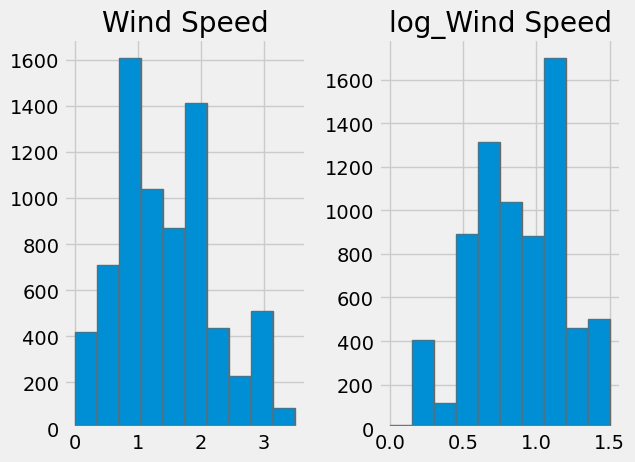

In [15]:
# create new dataframe to compare the original vs log transform data
dist_df = pd.DataFrame({'Wind Speed' : data['Wind Speed'].values, 'log_Wind Speed' : dataset[:,0]})

# histogram plot original vs log transform data
plt.figure(figsize=(12,5))
dist_df.hist();

In [16]:
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

5490 1831


In [20]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print('Shape of trainX :', trainX.shape)
print('Shape of trainY :', trainY.shape)
print('Shape of testX :', testX.shape)
print('Shape of testY :', testY.shape)

Shape of trainX : (5488, 1)
Shape of trainY : (5488,)
Shape of testX : (1829, 1)
Shape of testY : (1829,)


In [21]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print('Shape of trainX :', trainX.shape)
print('Shape of testX :', testX.shape)

Shape of trainX : (5488, 1, 1)
Shape of testX : (1829, 1, 1)


In [22]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=1000, batch_size=32, verbose=2)

Epoch 1/1000


2024-06-23 10:28:41.189067: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


172/172 - 1s - 8ms/step - loss: 0.8019
Epoch 2/1000
172/172 - 0s - 1ms/step - loss: 0.2451
Epoch 3/1000
172/172 - 0s - 1ms/step - loss: 0.0741
Epoch 4/1000
172/172 - 0s - 906us/step - loss: 0.0581
Epoch 5/1000
172/172 - 0s - 903us/step - loss: 0.0566
Epoch 6/1000
172/172 - 0s - 1ms/step - loss: 0.0551
Epoch 7/1000
172/172 - 0s - 1ms/step - loss: 0.0538
Epoch 8/1000
172/172 - 0s - 1ms/step - loss: 0.0524
Epoch 9/1000
172/172 - 0s - 1ms/step - loss: 0.0511
Epoch 10/1000
172/172 - 0s - 1ms/step - loss: 0.0500
Epoch 11/1000
172/172 - 0s - 936us/step - loss: 0.0489
Epoch 12/1000
172/172 - 0s - 1ms/step - loss: 0.0480
Epoch 13/1000
172/172 - 0s - 999us/step - loss: 0.0475
Epoch 14/1000
172/172 - 0s - 1ms/step - loss: 0.0468
Epoch 15/1000
172/172 - 0s - 1ms/step - loss: 0.0466
Epoch 16/1000
172/172 - 0s - 778us/step - loss: 0.0462
Epoch 17/1000
172/172 - 0s - 1ms/step - loss: 0.0462
Epoch 18/1000
172/172 - 0s - 1ms/step - loss: 0.0459
Epoch 19/1000
172/172 - 0s - 2ms/step - loss: 0.0458
Epoch

In [23]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = np.expm1(trainPredict)
trainY = np.expm1(trainY)
testPredict = np.expm1(testPredict)
testY = np.expm1(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step
Train Score: 0.48 RMSE
Test Score: 0.56 RMSE


In [24]:
test_series = pd.Series(testY)

# state of model performance
if testScore < test_series.std():
    print('\n[ Model performance is GOOD enough ]')
    print('\nRMSE of test prediction < Standard deviation of test dataset')
    print('%.2f' % (testScore), '<', '%.2f' % (test_series.std()))
else:
    print('\n[ Model performance is NOT GOOD enough ]')
    print('\nRMSE of test prediction > Standard deviation of test dataset')
    print('%.2f' % (testScore), '>', '%.2f' % (test_series.std()))


[ Model performance is GOOD enough ]

RMSE of test prediction < Standard deviation of test dataset
0.56 < 0.77


In [26]:
trainPredict.shape

(5488, 1)

In [27]:
dataset.shape

(7321, 1)

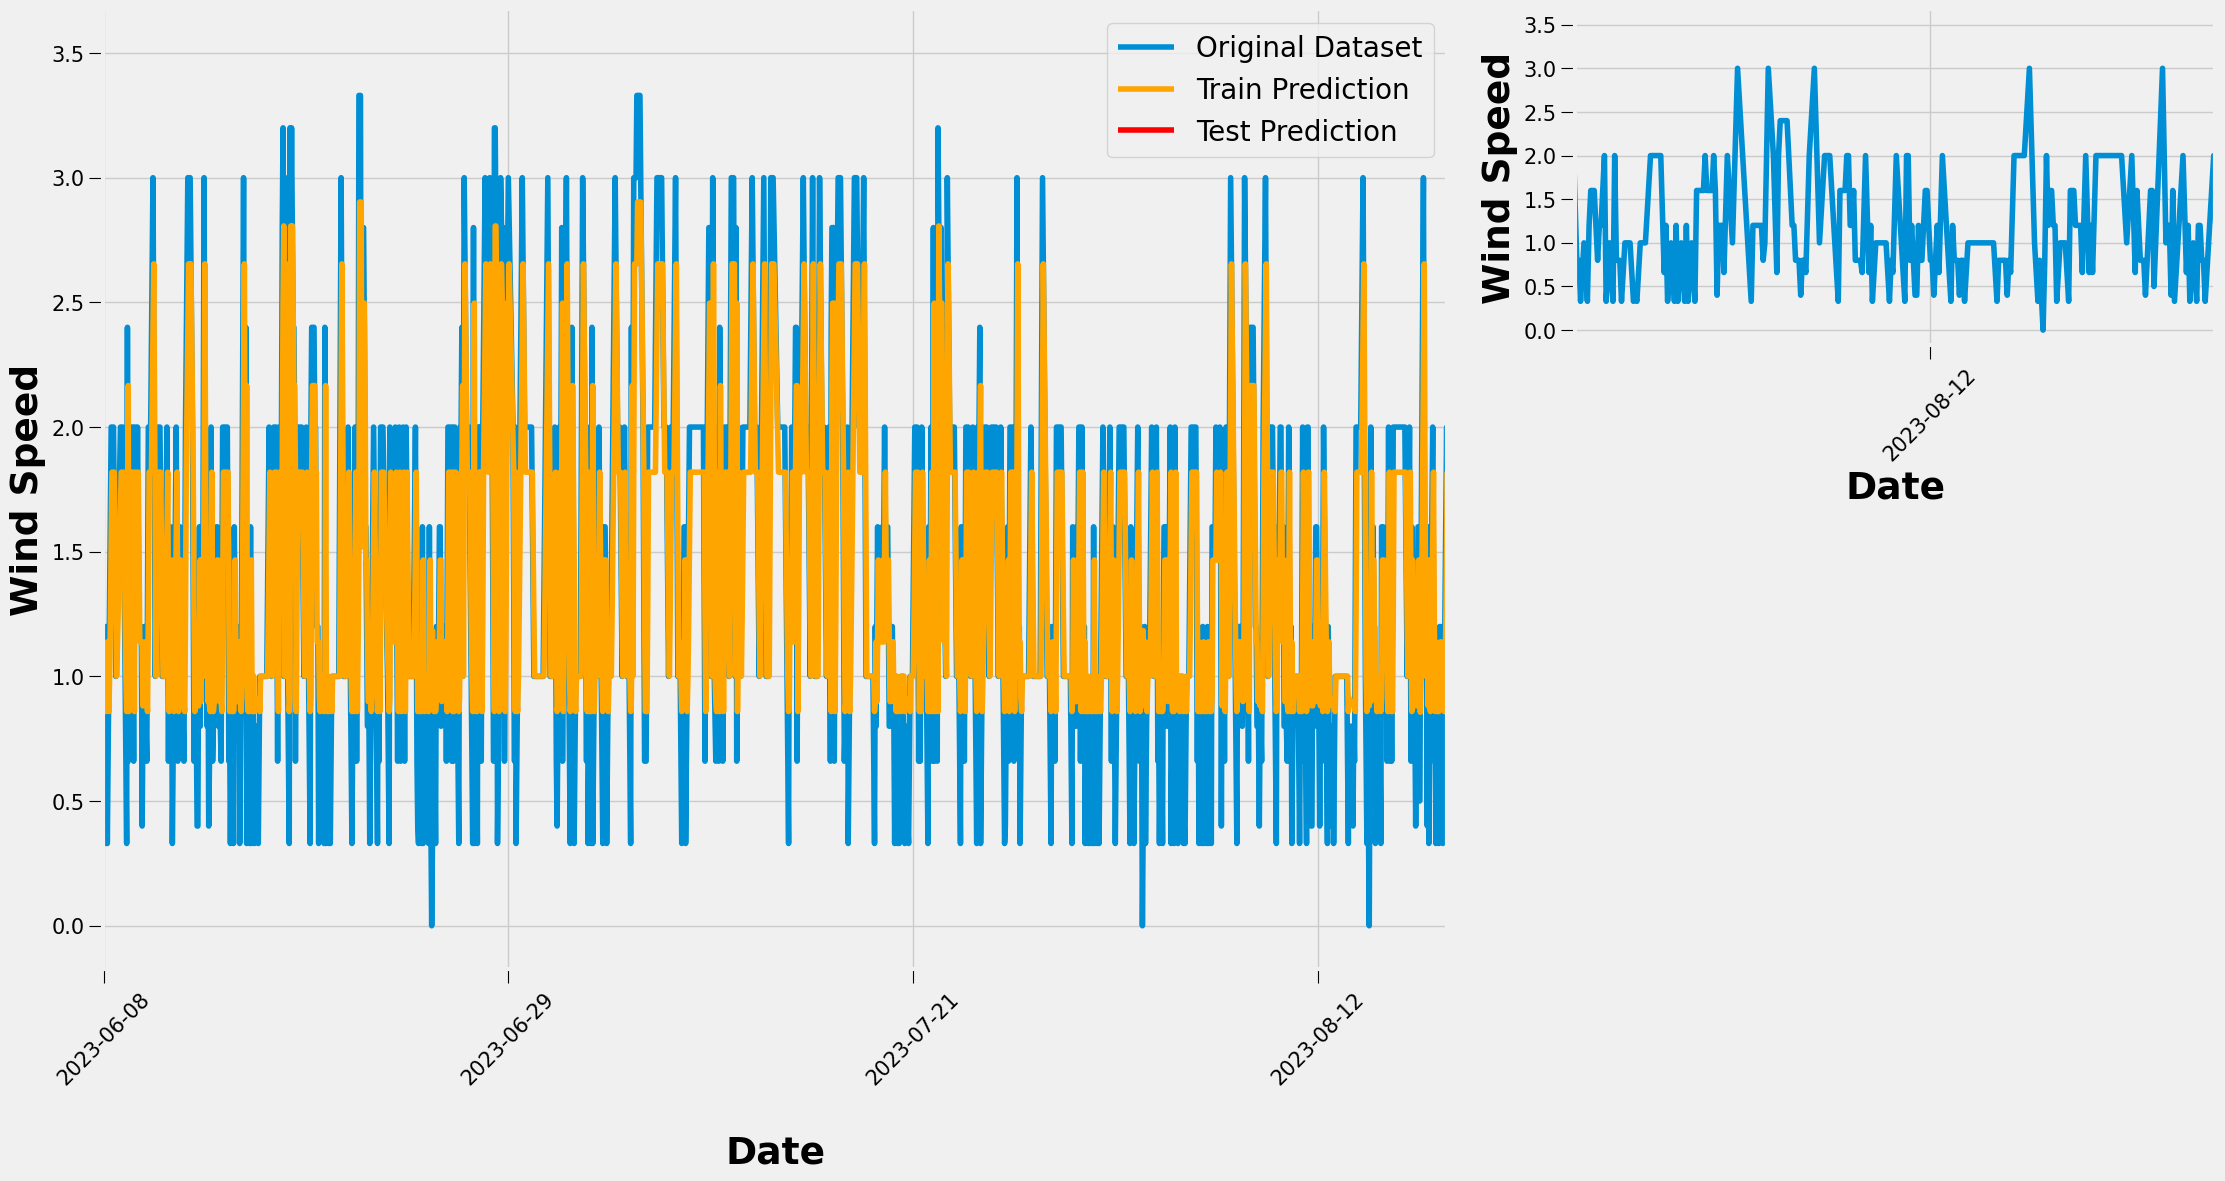

In [25]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot original dataset and predictions
time_axis = np.linspace(0, dataset.shape[0]-1, 15)
time_axis = np.array([int(i) for i in time_axis])
time_axisLab = np.array(data.index, dtype='datetime64[D]')

fig = plt.figure()
ax = fig.add_axes([0, 0, 2.1, 2])
ax.plot(np.expm1(dataset), label='Original Dataset')
ax.plot(trainPredictPlot, color='orange', label='Train Prediction')
ax.plot(testPredictPlot, color='red', label='Test Prediction')
ax.set_xticks(time_axis)
ax.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax.set_xlabel('\nDate', fontsize=27, fontweight='bold')
ax.set_ylabel('Wind Speed', fontsize=27, fontweight='bold')
ax.legend(loc='best', prop= {'size':20})
ax.tick_params(size=10, labelsize=15)
ax.set_xlim([-1,1735])

ax1 = fig.add_axes([2.3, 1.3, 1, 0.7])
ax1.plot(np.expm1(dataset), label='Original Dataset')
ax1.plot(testPredictPlot, color='red', label='Test Prediction')
ax1.set_xticks(time_axis)
ax1.set_xticklabels(time_axisLab[time_axis], rotation=45)
ax1.set_xlabel('Date', fontsize=27, fontweight='bold')
ax1.set_ylabel('Wind Speed', fontsize=27, fontweight='bold')
ax1.tick_params(size=10, labelsize=15)
ax1.set_xlim([1360,1735]);

In [28]:
trainPredict.shape

(5488, 1)

In [29]:
testPredict.shape

(1829, 1)

In [30]:
len(dataset)

7321